# PROYECTO SERIES TEMPORALES

Manuel Rodríguez-Piñero Jiménez

## 0. Introducción

Lo primero que hago es importar librerías y cargar los datos

In [1]:
# imports base
import pandas as pd
import numpy as np

# Summary stats
import skimpy as sk

# plots
import matplotlib.pyplot as plt
#%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import seaborn as sns
pd.options.plotting.backend = "plotly"


# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, make_scorer

# utilidades varias
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# series temporales
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import het_white
import pymannkendall as mk

from prophet import Prophet
from prophet.plot import plot_cross_validation_metric, plot, plot_components
from prophet.diagnostics import cross_validation, performance_metrics


from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pylab import rcParams

rcParams['figure.figsize'] = 15, 12

plt.style.use('seaborn-v0_8')
from catboost import CatBoostRegressor


Tengo dos datasets disponibles, los voy a cargar.

In [2]:
CWD = os.getcwd() #vemos el directorio actual
DATA_PATH = os.path.join(CWD) 
df1 = pd.read_csv(os.path.join(DATA_PATH, "retail_todo_ventas.csv"))
df2 = pd.read_csv(os.path.join(DATA_PATH, "prod_dict.csv"))


In [3]:
# defino funcion para calcular metrica smape
def metrica_smape(y_real, y_pred):
    numerator = np.abs(y_real - y_pred)
    denominator = (np.abs(y_real) + np.abs(y_pred)) / 2
    smape = np.mean(numerator / denominator) 
    return smape

In [4]:
#Defino función errores que usaré durante el proyecto,esta recibe los valores reales y los predichos y devuelve un dataframe con los errores MAE, RMSE,MAPE ySMAPE
def errores (y_real, y_pred):
    pd.set_option('display.float_format', '{:.2f}'.format)
    mae = mean_absolute_error(y_real, y_pred)
    rmse = root_mean_squared_error(y_real, y_pred)
    y_real
    mape = mean_absolute_percentage_error(y_real, y_pred)
    smape = metrica_smape(y_real, y_pred)
    
    return pd.DataFrame(data = [mae, rmse,mape,smape], index = ['MAE','RMSE','MAPE','SMAPE'], columns = ['Errores'])

## 1.Exploración de los datos

In [5]:
display(df1.head())
display(df1.shape)

display(df2.head())
display(df2.shape)

InvoiceNo StockCode        Date         Country  TotalSales
0    536365     21730  2022-12-01  United Kingdom       25.50
1    536365     22752  2022-12-01  United Kingdom       15.30
2    536365     71053  2022-12-01  United Kingdom       20.34
3    536365    84029E  2022-12-01  United Kingdom       20.34
4    536365    84029G  2022-12-01  United Kingdom       20.34

(394330, 5)

StockCode                   Description
0     10002    INFLATABLE POLITICAL GLOBE
1     10080      GROOVY CACTUS INFLATABLE
2     10120                  DOGGY RUBBER
3     10125       MINI FUNKY DESIGN TAPES
4     10133  COLOURING PENCILS BROWN TUBE

(3922, 2)

El primer dataset contiene en cada fila, un numéro de factura(InvoiceNo), una fecha, un país,el número de ventas(debe ser en euros,e.d, no número de productos vendidos sino el dinero por el que se vendieron esos productos) y el código de indentificación del producto vendido(StockCode).\
El segundo contiene 2 columnas, la primera es el StockCode y la segunda es la descripción del producto.

Entonces voy a juntar ambos dataframes  añadiendo la columna Description al primer dataframe según el StockCode.\
Antes voy a ver si el número de valores únicos de StockCode coincide en ambos dataframes

In [6]:
print(df1.StockCode.nunique()) # nº de valores únicos de StockCode en df1
print(df2.StockCode.nunique()) # nº de valores únicos de StockCode en df2

3697
3697


Me sorprende que el número de filas de df2 sea mayor que el número de valores únicos de StockCode.\
Esto no debería ocurrir ya implica que hay filas con StockCode repetidos lo que significa que hay productos con más de una descripción.\
Veamos cuales son esos productos

In [7]:
df2[df2.StockCode.duplicated(keep=False)].sort_values('StockCode')

StockCode                          Description
38      16156L                       WRAP, CAROUSEL
39      16156L                        WRAP CAROUSEL
94      17107D  FLOWER FAIRY,5 SUMMER B'DRAW LINERS
95      17107D         FLOWER FAIRY 5 DRAWER LINERS
96      17107D    FLOWER FAIRY 5 SUMMER DRAW LINERS
...        ...                                  ...
3576    90014A         SILVER M.O.P. ORBIT NECKLACE
3577    90014B         GOLD M PEARL  ORBIT NECKLACE
3578    90014B           GOLD M.O.P. ORBIT NECKLACE
3579    90014C          SILVER/BLACK ORBIT NECKLACE
3580    90014C      SILVER AND BLACK ORBIT NECKLACE

[432 rows x 2 columns]

Se observa que para algunos StockCode hay descripciones que básicamente son iguales pero con distintas palabras.\
Vamos a eliminar duplicados quedándonos con la primera descripción que aparezca para StockCode

In [8]:
df2.drop_duplicates(subset=['StockCode'], keep='first',inplace=True) 
df2.reset_index(drop=True, inplace=True) #reseteo el índice
#Compruebo si ahora coincide el número de filas de df2 y el número de valores únicos
display(len(df2)==df2.StockCode.nunique())

True

Voy a comprobar si hubiera duplicados en df1

In [9]:
df1[df1.duplicated(keep=False)]

InvoiceNo StockCode        Date         Country  TotalSales
145881    554084     23298  2023-05-22  United Kingdom       14.85
145882    554084     23298  2023-05-22  United Kingdom       14.85
329558    575335     23203  2023-11-09  United Kingdom      537.00
329559    575335     23203  2023-11-09  United Kingdom      537.00

In [10]:
#Elimino duplicados de df1
df1.drop_duplicates(inplace=True)
df1.reset_index(drop=True, inplace=True) #reseteo el índice

Ahora ya sí voy a unir ambos dataframes por la columna StockCode

In [11]:
df= pd.merge(df1,df2, on=['StockCode'], how='left')
display(df.head())
display(df.shape)
display(df1.head())
display(df1.shape)

InvoiceNo StockCode        Date         Country  TotalSales  \
0    536365     21730  2022-12-01  United Kingdom       25.50   
1    536365     22752  2022-12-01  United Kingdom       15.30   
2    536365     71053  2022-12-01  United Kingdom       20.34   
3    536365    84029E  2022-12-01  United Kingdom       20.34   
4    536365    84029G  2022-12-01  United Kingdom       20.34   

                           Description  
0    GLASS STAR FROSTED T-LIGHT HOLDER  
1         SET 7 BABUSHKA NESTING BOXES  
2                  WHITE METAL LANTERN  
3       RED WOOLLY HOTTIE WHITE HEART.  
4  KNITTED UNION FLAG HOT WATER BOTTLE

(394328, 6)

InvoiceNo StockCode        Date         Country  TotalSales
0    536365     21730  2022-12-01  United Kingdom       25.50
1    536365     22752  2022-12-01  United Kingdom       15.30
2    536365     71053  2022-12-01  United Kingdom       20.34
3    536365    84029E  2022-12-01  United Kingdom       20.34
4    536365    84029G  2022-12-01  United Kingdom       20.34

(394328, 5)

df y df1 tienen las mimas filas, y df tienen una columna más (Description) así que la unión de los dataframes se ha realizado correctamente.\
Vamos ahora a ver un resumen de la información de df y una estadística básica

In [12]:
display(sk.skim(df))
display(df.info())
display(df.describe(include='all'))


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 394328 │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 5      │ │ float64     │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name     ┃ NA   ┃ NA %   ┃ mean     ┃ sd      ┃ p0   ┃ p25    ┃ p50     ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ TotalSales      │    0 │      0 │    24.49 │   103.7 │    0 │   7.38 │   13.52 │   19.9 │  38970 │    ▇    │  │
│ └─────────────────┴──────┴────────┴──────────┴─────────┴──────┴────────┴─────────┴────────┴────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ StockCode                 │       0 │          0 │                            1 │                   394339 │  │
│ │ Date                      │       0 │          0 │                            1 │                   394328 │  │
│ │ Country                   │       0 │          0 │                          1.9 │                   761651 │  │
│ │ Description               │       0 │          0 │                          4.4 │                  1743092 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394328 entries, 0 to 394327
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    394328 non-null  object 
 1   StockCode    394328 non-null  object 
 2   Date         394328 non-null  object 
 3   Country      394328 non-null  object 
 4   TotalSales   394328 non-null  float64
 5   Description  394328 non-null  object 
dtypes: float64(1), object(5)
memory usage: 18.1+ MB


None

InvoiceNo StockCode        Date         Country     TotalSales  \
count    394328.0    394328      394328          394328  394328.000000   
unique    19302.0      3697         305              10            NaN   
top      573585.0    85123A  2023-12-05  United Kingdom            NaN   
freq        833.0      2168        3898          367323            NaN   
mean          NaN       NaN         NaN             NaN      24.487220   
std           NaN       NaN         NaN             NaN     103.723912   
min           NaN       NaN         NaN             NaN       0.000000   
25%           NaN       NaN         NaN             NaN       7.380000   
50%           NaN       NaN         NaN             NaN      13.520000   
75%           NaN       NaN         NaN             NaN      19.900000   
max           NaN       NaN         NaN             NaN   38970.000000   

                               Description  
count                               394328  
unique                                3673  
top     WHITE HANGING HEART T-LIGHT HOLDER  
freq                                  2168  
mean                                   NaN  
std                                    NaN  
min                                    NaN  
25%                                    NaN  
50%                                    NaN  
75%                                    NaN  
max                                    NaN

De primeras observamos que no hay nulos y que la columna Date no está en formato fecha, así que lo voy a corregir,\
El InvoiceNo aunque sea un número no lo cambio a tipo numérico porque es un identificador.


In [13]:
#Cambio el tipo de estas columnas a str:
for c in ['InvoiceNo','StockCode','Country','Description']:
    df[c] = df[c].astype('str')
    
#Voy a transformar la columna Date en formato fecha.
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
display(df.dtypes)

InvoiceNo              object
StockCode              object
Date           datetime64[ns]
Country                object
TotalSales            float64
Description            object
dtype: object

En cuanto a la columna TotalSales, el mínimo es 0, que no puede ser ya que esos productos se estarían vendiendo gratis\, 
voy a ver que productos son estos:

In [14]:
df.query('TotalSales==@df.TotalSales.min()').describe(include='all')

InvoiceNo StockCode                 Date         Country  TotalSales  \
count         63        63                   63              63        63.0   
unique         1        63                  NaN               1         NaN   
top       539856    18098C                  NaN  United Kingdom         NaN   
freq          63         1                  NaN              63         NaN   
mean         NaN       NaN  2022-12-22 00:00:00             NaN         0.0   
min          NaN       NaN  2022-12-22 00:00:00             NaN         0.0   
25%          NaN       NaN  2022-12-22 00:00:00             NaN         0.0   
50%          NaN       NaN  2022-12-22 00:00:00             NaN         0.0   
75%          NaN       NaN  2022-12-22 00:00:00             NaN         0.0   
max          NaN       NaN  2022-12-22 00:00:00             NaN         0.0   
std          NaN       NaN                  NaN             NaN         0.0   

                           Description  
count                               63  
unique                              63  
top     PORCELAIN BUTTERFLY OIL BURNER  
freq                                 1  
mean                               NaN  
min                                NaN  
25%                                NaN  
50%                                NaN  
75%                                NaN  
max                                NaN  
std                                NaN

Vemos que TotalSales = 0 solo ocurre para 1 InvoiceNo(el '539856'), en un solo país('United Kingdom) y en una sola fecha('2022-12-22').\
En cuanto a los prodictos(StockCode), son todos diferentes. Así que, para cada producto, voy a cambiar el valor de 'TotaSales' por la media \
de ese producto en 'United Kingdom'.

Pero antes voy a cambiar los espacios de la columna Country por barra baja por comodidad


In [15]:
df.Country = df.Country.str.replace(' ','_')
df.head()

InvoiceNo StockCode       Date         Country  TotalSales  \
0    536365     21730 2022-12-01  United_Kingdom       25.50   
1    536365     22752 2022-12-01  United_Kingdom       15.30   
2    536365     71053 2022-12-01  United_Kingdom       20.34   
3    536365    84029E 2022-12-01  United_Kingdom       20.34   
4    536365    84029G 2022-12-01  United_Kingdom       20.34   

                           Description  
0    GLASS STAR FROSTED T-LIGHT HOLDER  
1         SET 7 BABUSHKA NESTING BOXES  
2                  WHITE METAL LANTERN  
3       RED WOOLLY HOTTIE WHITE HEART.  
4  KNITTED UNION FLAG HOT WATER BOTTLE

In [16]:
# A cada producto le asigno el número de ventas promedio en Uk
for stock in df.query('TotalSales==@df.TotalSales.min()').StockCode.unique():
    ind = df.query('TotalSales==@df.TotalSales.min()').query('StockCode==@stock').index[0]
    df.loc[ind,'TotalSales']=\
          df.query('TotalSales>0 & Country=="United_Kingdom"').query('StockCode==@stock')['TotalSales'].mean()
    
#Compruebo que lo he hecho bien, estudiando como quedan los valores para el InvoiceNo donde tenía los ceros
display(df.query("InvoiceNo=='539856'").TotalSales.describe())      

count      64.000000
mean       38.836165
std       160.420535
min         8.054122
25%        12.258570
50%        15.372447
75%        21.037743
max      1298.400000
Name: TotalSales, dtype: float64

Efectivamente el valor mínimo ya no es cero

### Separo por países
Queremos predecir las ventas por país, así  que voy a hacer un dataframe para cada país.

In [17]:
#Vamos a agrupar por país para ver cuantos datos tenemos de cada uno
display(df.groupby('Country').count().sort_values('StockCode', ascending=False))
print(f'Hay {df.Country.nunique()} países distintos')

InvoiceNo  StockCode    Date  TotalSales  Description
Country                                                              
United_Kingdom     367323     367323  367323      367323       367323
Germany              7040       7040    7040        7040         7040
France               6480       6480    6480        6480         6480
EIRE                 6129       6129    6129        6129         6129
Spain                1894       1894    1894        1894         1894
Netherlands          1791       1791    1791        1791         1791
Belgium              1592       1592    1592        1592         1592
Portugal             1151       1151    1151        1151         1151
Italy                 579        579     579         579          579
Sweden                349        349     349         349          349

Hay 10 países distintos


Debido a la enorme diferencia de ventas entre Uk y el resto de países supongo que esta empresa es una empresa de allí que también vende a otros países.

Voy a crear una lista con los nombres de los países abreviados para dar nombre a los diferentes dataframes

In [18]:
#lista de los paises que aparecen en el dataset
paises = df.Country.unique().tolist()
num_paises = len(paises)

display(paises)
display(num_paises)

['United_Kingdom',
 'France',
 'Netherlands',
 'Germany',
 'EIRE',
 'Spain',
 'Portugal',
 'Italy',
 'Belgium',
 'Sweden']

10

In [19]:
#lista con nombres de los países abreviados
paises_abr = ['uk','fr','neth','ger','eire','spain','port','it','bel','swe']

In [20]:
#Vamos a crear 10 dataframes correspondiente a cada país, lo haré con un bucle for:

dfs=[] #Creo una lista con los nombres de los df creados

for i in range(num_paises):
    country = paises[i] #pais que aparece en la posición i de la lista de paises de df

    #creo dataset para cada pais con nombre 'df_'+'pais_abreviado':
    globals()[f'df_{paises_abr[i]}'] = df.query('Country == @country') 

    #para cada dataset creado agrupo por fecha y sumo las ventas diarias,
    # me quedo solo con la fecha y el total de ventas. La de más información no la voy a utilizar.
    globals()[f'df_{paises_abr[i]}']= globals()[f'df_{paises_abr[i]}'].groupby('Date').agg(ventas_diarias=('TotalSales','sum'))

    print(f'Primera y última fecha de {country}:')
    display(globals()[f'df_{paises_abr[i]}'].head(1))
    display(globals()[f'df_{paises_abr[i]}'].tail(1))
    print('-----------------------------------')
    dfs.append('df_'+paises_abr[i])
print(dfs)    

Primera y última fecha de United_Kingdom:


ventas_diarias
Date                      
2022-12-01        53520.58

ventas_diarias
Date                      
2023-12-09        26956.27

-----------------------------------
Primera y última fecha de France:


ventas_diarias
Date                      
2022-12-01           792.9

ventas_diarias
Date                      
2023-12-09           211.8

-----------------------------------
Primera y última fecha de Netherlands:


ventas_diarias
Date                      
2022-12-01           177.6

ventas_diarias
Date                      
2023-12-07         10739.3

-----------------------------------
Primera y última fecha de Germany:


ventas_diarias
Date                      
2022-12-01          261.48

ventas_diarias
Date                      
2023-12-09         1530.77

-----------------------------------
Primera y última fecha de EIRE:


ventas_diarias
Date                      
2022-12-01          483.08

ventas_diarias
Date                      
2023-12-08          991.14

-----------------------------------
Primera y última fecha de Spain:


ventas_diarias
Date                      
2022-12-03           521.0

ventas_diarias
Date                      
2023-12-07           139.6

-----------------------------------
Primera y última fecha de Portugal:


ventas_diarias
Date                      
2022-12-03           101.8

ventas_diarias
Date                      
2023-12-07          366.62

-----------------------------------
Primera y última fecha de Italy:


ventas_diarias
Date                      
2022-12-03           354.7

ventas_diarias
Date                      
2023-12-06          183.95

-----------------------------------
Primera y última fecha de Belgium:


ventas_diarias
Date                      
2022-12-03           304.9

ventas_diarias
Date                      
2023-12-09           191.0

-----------------------------------
Primera y última fecha de Sweden:


ventas_diarias
Date                      
2022-12-14          1188.0

ventas_diarias
Date                      
2023-12-05           238.0

-----------------------------------
['df_uk', 'df_fr', 'df_neth', 'df_ger', 'df_eire', 'df_spain', 'df_port', 'df_it', 'df_bel', 'df_swe']


Pinto las series de cada páis tal como están

In [21]:
fig = make_subplots(rows=5, cols=2, subplot_titles=paises)

# Añadir cada gráfico al subplot correspondiente
for i in range(num_paises):
    df_temp = globals()[dfs[i]].copy()
    trace = go.Scatter(y=df_temp['ventas_diarias'], mode='lines', name=paises[i])

    # Calcular fila y columna para este gráfico
    row = (i // 2) + 1
    col = (i % 2) + 1

    # Añadir el gráfico a la figura
    fig.add_trace(trace, row=row, col=col)

# Ajustar el diseño
fig.update_layout(
    height=5 * 400,  # Ajustar la altura total de la figura
    width=2 * 600,   # Ajustar el ancho total de la figura
    showlegend=False    # Ocultar leyenda global
)

# Mostrar figura
fig.show()


Voy a crear nuevas columnas año, mes y día de la semana

In [22]:
for country in dfs:
    globals()[country]['year'] = globals()[country].index.year
    globals()[country]['month'] = globals()[country].index.month
    globals()[country]['day_name'] = globals()[country].index.day_name()
    display(globals()[country].head(1))

ventas_diarias  year  month  day_name
Date                                             
2022-12-01        53520.58  2022     12  Thursday

ventas_diarias  year  month  day_name
Date                                             
2022-12-01           792.9  2022     12  Thursday

ventas_diarias  year  month  day_name
Date                                             
2022-12-01           177.6  2022     12  Thursday

ventas_diarias  year  month  day_name
Date                                             
2022-12-01          261.48  2022     12  Thursday

ventas_diarias  year  month  day_name
Date                                             
2022-12-01          483.08  2022     12  Thursday

ventas_diarias  year  month  day_name
Date                                             
2022-12-03           521.0  2022     12  Saturday

ventas_diarias  year  month  day_name
Date                                             
2022-12-03           101.8  2022     12  Saturday

ventas_diarias  year  month  day_name
Date                                             
2022-12-03           354.7  2022     12  Saturday

ventas_diarias  year  month  day_name
Date                                             
2022-12-03           304.9  2022     12  Saturday

ventas_diarias  year  month   day_name
Date                                              
2022-12-14          1188.0  2022     12  Wednesday

## 2.Análisis Estadístico

Lo primero que voy a ver es la distribución de los valores de ventas_diarias mediante histogramas, boxplots y scatterplots

In [23]:


# Crear subplots
fig = make_subplots(
    rows=num_paises,
    cols=3,
        #histograma columna de la izq, boxplot en el medio y #scatterplot en la derecha
    subplot_titles=[f"{pais} Histogram" if i % 3 == 0 else (f"{pais} Boxplot" if i % 3 == 1 else f"{pais} Scatterplot") for pais in paises for i in range(3)],
    column_widths=[0.35, 0.2,0.45]  # Ajusttamaño de histograma, boxplot y scatterplot
)

# Añadir gráficos
for i in range(num_paises):
    df_temp = globals()[dfs[i]].copy()

    # Histograma
    hist = go.Histogram(
        x=df_temp['ventas_diarias'],
        name=f"{paises[i]} Hist",
        
    )

    # Boxplot
    box = go.Box(
        y=df_temp['ventas_diarias'],
        name=f"{paises[i]} Box",
        hovertext=df_temp.index
    )

    # Scatterplot
    scatter = go.Scatter(
        x=df_temp.index,
        y=df_temp['ventas_diarias'],
        mode='markers',
        name=f"{paises[i]} Scatter",
        hovertext = df_temp['day_name']
    )

    # Determinar las posiciones
    row = i + 1  # Una fila por país
    fig.add_trace(hist, row=row, col=1)  # Histograma en la primera columna
    fig.add_trace(box, row=row, col=2)  # Boxplot en la segunda columna
    fig.add_trace(scatter, row=row, col=3)  # Scatterplot en la tercera columna

# Actualizar diseño
fig.update_layout(
    height=num_paises*400,  # Altura proporcional al número de países
    width= 1300,             # Ancho fijo
    title="Histograma, Boxplot y Scatterplot por país",
    showlegend=False         # Ocultar leyenda global
)

# Mostrar figura
fig.show()


Se observa que en todos los países hay outliers muy grandes, veamos cuales son los de Uk (ya que es el país con mas ventas) para ver\
si las fechas en las que ocurren son especiales (como por ejemplo BlackFriday)

In [24]:
Q1_uk = df_uk['ventas_diarias'].quantile(0.25) #1º Cuartil de UK
Q3_uk = df_uk['ventas_diarias'].quantile(0.75) #2º Cuartil de UK
IQR_uk = Q3_uk - Q1_uk  # Rango intercuartílico de UK

# Limites
lower_limit_uk = Q1_uk - 1.5 * IQR_uk
upper_limit_uk = Q3_uk + 1.5 * IQR_uk

# Identificar outliers
df_uk_outliers = df_uk[(df_uk['ventas_diarias'] < lower_limit_uk) | (df_uk['ventas_diarias'] > upper_limit_uk)]
df_uk_outliers

ventas_diarias  year  month   day_name
Date                                              
2022-12-07        95794.19  2022     12  Wednesday
2023-09-15        72910.30  2023      9     Friday
2023-09-20       105583.91  2023      9  Wednesday
2023-10-03        64983.43  2023     10    Tuesday
2023-11-07        81664.45  2023     11    Tuesday
2023-11-14       107229.10  2023     11    Tuesday
2023-12-05        83274.82  2023     12    Tuesday
2023-12-08        77242.10  2023     12     Friday

Vemos que hay 3 fechas que son de diciembre, que podría ser por cercanía a las Navidades.\
Hay dos en Noviembre que podría ser por cercanía a el BlackFriday.\
En el resto de días podría haber habido ofertas, pueden ser errores en los datos o simplemente que no haya ninguna razón conocida

De todos  todos como no conocemos las fechas de esas posibles ofertas, y como mi rango de fechas es de prácticamente 1 año no podemos saber\
si en otros años tambíen se incrementan las ventas para esas fechas

Ahora voy a ver la distribución de ventas por día de la semana

In [25]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# Crear subplots
fig = make_subplots(rows=5, cols=2, subplot_titles=paises)

# Añadir gráficos a las subplots
for i in range(num_paises):
    df_temp = globals()[dfs[i]].groupby('day_name').agg(ventas_por_dia=('ventas_diarias', 'mean'))
    df_temp.index = pd.CategoricalIndex(df_temp.index, categories=day_order, ordered=True)
    df_temp.sort_index(inplace=True)

    # Crear gráfico de barras
    bar = go.Bar(x=df_temp.index, y=df_temp['ventas_por_dia'] , name=paises[i])

    # Determinar la fila y columna
    row = (i // 2) + 1 #paises 0,1 en la primera fila; paises 2,3 en la segunda fila...
    col = (i % 2) + 1  #paises pares en la columna 1; países impares en la columna 2

    # Añadir el gráfico a la figura
    fig.add_trace(bar, row=row, col=col)

# Actualizar diseño
fig.update_layout(
    height=num_paises*200,  
    width= 1000,   
    showlegend=True    
)

# Mostrar figura
fig.show()


### Fechas faltantes

Viendo estos gráficos ya sabemos que los domingos esta empresa está cerrada en todos los países.\
Habíamos visto antes que no había nulos pero eso no quiere decir que no haya  fechas faltantes.\
Por lo pronto faltan todos los domingos pero los vamos a incluir asumiendo que las ventas son 0 para todos los domingos.\
Voy a utilizar la fecha mínima  y la fecha máxima del dataset de todos los países como el rango en el que dispongo de los datos.

In [26]:
# Voy a ver el rango de fechas que tengo en mi dataset
fecha_min = df.Date.min()
fecha_max = df.Date.max()
fecha_rango = pd.date_range(start=fecha_min, end=fecha_max, freq='D') #me da las fechas del rango en el que tengo datos
print(f'Fecha minima: {fecha_min.strftime("%Y/%m/%d")}\nFecha máxima: {fecha_max.strftime("%Y/%m/%d")}')
print(f'Número de días: {len(fecha_rango)}') #numero de días del rango

Fecha minima: 2022/12/01
Fecha máxima: 2023/12/09
Número de días: 374


Para cada país cre ahora un nuevo dataframe que llamaré df_pais_comp donde incluiremos las fechas faltantes.\
Primero creamos estos dataframes como copias de los que ya tenemos

In [27]:
#Creo nuevos dataframes a los que voy a añadir fechas faltantes
dfs_comp = [] #lista con los df que voy a completar creados
for country in dfs:
    globals()[f'{country}_comp'] = globals()[country].copy()
    dfs_comp.append(country+'_comp')
display(dfs_comp)

['df_uk_comp',
 'df_fr_comp',
 'df_neth_comp',
 'df_ger_comp',
 'df_eire_comp',
 'df_spain_comp',
 'df_port_comp',
 'df_it_comp',
 'df_bel_comp',
 'df_swe_comp']

Ahora voy a incluir en estos dataframes los domingos

In [28]:
#Creo un dataframe con los domingos
domingos = fecha_rango[fecha_rango.weekday==6] #de mi rango de fechas, las que son domingo
df_domingos = pd.DataFrame({'ventas_diarias': 0}, index=domingos) #creo df con las fechas de los domingos y le asigno 0 a ventas_diarias
df_domingos['year'] = df_domingos.index.year #saco el año, mes y día de las nuevas columnas
df_domingos['month'] = df_domingos.index.month
df_domingos['day_name'] = df_domingos.index.day_name()

# a todos los dataframes que tengo les añado df_domingos
for country in dfs_comp:
    globals()[country] = pd.concat([globals()[country], df_domingos]).sort_index() #concateno y ordeno por el índice


A parte de los domingos puede haber días en los que la empresa cierre.\
Voy a crear un dataframe con las vacaciones de cada país en 2022, 2023 y 2024

In [29]:
# Creo un dataframe con las vacaciones de cada país
paises_vac = ['UK','France','Netherlands','Germany','IE','Spain','Portugal','Italy','Belgium','Sweden']

#Las vacaciones las conseguimos de la libreria Prophet
from prophet.make_holidays import make_holidays_df
dfs_vac = [] #lista con los df de vac creados
for i in range(num_paises):
    globals()[f'df_{paises_abr[i]}_vac'] = make_holidays_df(year_list=[2022,2023,2024], country=paises_vac[i]).sort_values('ds').reset_index(drop=True)
    dfs_vac.append(f'df_{paises_abr[i]}_vac')
display(dfs_vac)

    

['df_uk_vac',
 'df_fr_vac',
 'df_neth_vac',
 'df_ger_vac',
 'df_eire_vac',
 'df_spain_vac',
 'df_port_vac',
 'df_it_vac',
 'df_bel_vac',
 'df_swe_vac']

Ahora voy a comprobar si en los días festivos de cada país hubo ventas en el resto

In [30]:
for y in range(num_paises):
    fechas = []
    numero = 0
    print(f' Con vacaciones de {paises[y]}')
    df_temp_vac = globals()[dfs_vac[y]].copy()
    for x in range(num_paises):
        df_temp = globals()[dfs_comp[x]].copy()
        for i in range(len(df_temp)):
            if df_temp.index[i].date().strftime('%Y-%m-%d') in df_temp_vac.ds.dt.strftime('%Y-%m-%d').tolist()\
             and df_temp.index[i].day_name()!='Sunday':
                numero+=1
                fechas.append(df_temp.index[i].date().strftime('%Y-%m-%d'))
    fechas = set(fechas)
    print(f'Hay {len(fechas)} días festivos en los que sí hubo ventas')
    #print(fechas)
    print('---------------------')



 Con vacaciones de United_Kingdom
Hay 4 días festivos en los que sí hubo ventas
---------------------
 Con vacaciones de France
Hay 9 días festivos en los que sí hubo ventas
---------------------
 Con vacaciones de Netherlands
Hay 4 días festivos en los que sí hubo ventas
---------------------
 Con vacaciones de Germany
Hay 6 días festivos en los que sí hubo ventas
---------------------
 Con vacaciones de EIRE
Hay 7 días festivos en los que sí hubo ventas
---------------------
 Con vacaciones de Spain
Hay 10 días festivos en los que sí hubo ventas
---------------------
 Con vacaciones de Portugal
Hay 11 días festivos en los que sí hubo ventas
---------------------
 Con vacaciones de Italy
Hay 8 días festivos en los que sí hubo ventas
---------------------
 Con vacaciones de Belgium
Hay 8 días festivos en los que sí hubo ventas
---------------------
 Con vacaciones de Sweden
Hay 9 días festivos en los que sí hubo ventas
---------------------


Había supuesto al principo que esta empresa debía ser de Uk, por tanto tienen sentido que  haya más dias festivos de otros países,\
que días festivos de UK en los que sí hubo ventas.\
Es importante saber que la empresa es de Uk ya que los días festivos que me interesan son los de Uk, ya que los días festivos en otros países no\
influyen en si la empresa abre o no.

Por tanto, a apartir de ahora solo trabajaré con los festivos de Uk


In [31]:
df_vac = df_uk_vac.copy()

Voy a ver que para  que días festivos correspondientes a mi rango de fechas,\
la empresa abrió y para cuales cerró. Para ello voy a ver las fechas en las que no hubo ventas en Uk,\
ya que la empresa es de UK 

In [32]:
# Días festivos correspondiente al rango de fechas de los datos
df_vac_rango = df_vac[df_vac.ds.dt.strftime('%Y-%m-%d').isin(fecha_rango.strftime('%Y-%m-%d'))]

df_vac_rango['hubo_ventas' ]= 0

#si el festivo esta en  las fechas de Uk le asigno un 1 a hubo_ventas
df_vac_rango.loc[df_vac_rango.ds.dt.strftime('%Y-%m-%d').isin(df_uk_comp.index.strftime('%Y-%m-%d')),'hubo_ventas'] = 1

#Si el festivo es domingo le asigno un 0 a hubo_ventas
df_vac_rango.loc[df_vac_rango.ds.dt.day_name()=='Sunday','hubo_ventas'] = 0

df_vac_rango['dia_semana'] = df_vac_rango.ds.dt.day_name()
df_vac_rango



ds                    holiday  hubo_ventas dia_semana
7  2022-12-25              Christmas Day            0     Sunday
8  2022-12-26                 Boxing Day            0     Monday
9  2022-12-27   Christmas Day (observed)            0    Tuesday
10 2023-01-01             New Year's Day            0     Sunday
11 2023-01-02  New Year's Day (observed)            0     Monday
12 2023-04-07                Good Friday            1     Friday
13 2023-05-01                    May Day            1     Monday
14 2023-05-08  Coronation of Charles III            1     Monday
15 2023-05-29        Spring Bank Holiday            1     Monday

Voy a asumir que esta empresa en años futuros cerrará en todos los festivos menos en\
Good Friday, May Day, Spring Bank Holiday y Coronation of Charles III

Ya se que para domingos, y ciertos días festivos la empresa cierra. Sin embargo puede haber días en los que no sea\
festivo y yo no tenga datos, veamos si es así.\
Para el dataset de Uk (ya con los domingos metidos) voy a ver si hay más fechas faltantes que no son festivos:

In [33]:
fechas_faltantes_uk = fecha_rango.difference(df_uk_comp.index)
df_fechas_faltantes_uk = pd.DataFrame(data=[fechas_faltantes_uk.date,fechas_faltantes_uk.day_name()]).T
df_fechas_faltantes_uk.columns = ['fecha','dia']
df_fechas_faltantes_uk['fecha'] = pd.to_datetime(df_fechas_faltantes_uk['fecha'])

df_fechas_faltantes_uk ['es_festivo'] = 0
df_fechas_faltantes_uk.loc[df_fechas_faltantes_uk.fecha.dt.strftime('%Y-%m-%d').isin(\
    df_vac.ds.dt.strftime('%Y-%m-%d')),'es_festivo'] = 1
df_fechas_faltantes_uk


fecha        dia  es_festivo
0  2022-12-24   Saturday           0
1  2022-12-26     Monday           1
2  2022-12-27    Tuesday           1
3  2022-12-28  Wednesday           0
4  2022-12-29   Thursday           0
5  2022-12-30     Friday           0
6  2022-12-31   Saturday           0
7  2023-01-02     Monday           1
8  2023-01-03    Tuesday           0
9  2023-04-22   Saturday           0
10 2023-04-24     Monday           0
11 2023-04-25    Tuesday           0
12 2023-04-29   Saturday           0
13 2023-05-02    Tuesday           0
14 2023-05-30    Tuesday           0
15 2023-08-29    Tuesday           0

Voy a ver ahora si esas fechas faltantes lo  son también para el resto de países


In [34]:
#Muestro las fechas faltantes de Uk que sí aparecen otros paíes
for x in range(num_paises): 
    print(paises[x])
    df_temp = globals()[dfs_comp[x]]
    display(df_uk_comp[df_uk_comp.index.isin(df_fechas_faltantes_uk.fecha)])
    print('--------------')

United_Kingdom


Empty DataFrame
Columns: [ventas_diarias, year, month, day_name]
Index: []

--------------
France


Empty DataFrame
Columns: [ventas_diarias, year, month, day_name]
Index: []

--------------
Netherlands


Empty DataFrame
Columns: [ventas_diarias, year, month, day_name]
Index: []

--------------
Germany


Empty DataFrame
Columns: [ventas_diarias, year, month, day_name]
Index: []

--------------
EIRE


Empty DataFrame
Columns: [ventas_diarias, year, month, day_name]
Index: []

--------------
Spain


Empty DataFrame
Columns: [ventas_diarias, year, month, day_name]
Index: []

--------------
Portugal


Empty DataFrame
Columns: [ventas_diarias, year, month, day_name]
Index: []

--------------
Italy


Empty DataFrame
Columns: [ventas_diarias, year, month, day_name]
Index: []

--------------
Belgium


Empty DataFrame
Columns: [ventas_diarias, year, month, day_name]
Index: []

--------------
Sweden


Empty DataFrame
Columns: [ventas_diarias, year, month, day_name]
Index: []

--------------


Como se oberva, no hay ninguna fecha. Esto puede suponer que para esos días la empresa estuvo cerrada, lo cual podría tener sentido para fechas cercanas\
a festivos (como poir ejemplo el 24-12 o el 31-12). Sin embargo, aunque es una posibilidad , no es una certeza.\
Como no tenemos datos de años atrás para corroborar si en esos años la empresa cerró también en esos días, voy a suponer que en\
las fechas faltantes(que no correspondan a festivos) sí que hubo ventas pero que no tengo los datos

Entonces, he concluido que  esta empresa en años futuros cerrará en todos los festivos menos en\
Good Friday, May Day, Spring Bank Holiday y Coronation of Charles III y por tanto asignaré valor 0.\
Mientras que para las demás fechas faltantes de momento las añadiré como nulos en el valor de vetas\
y esos nulos los imputaré más adelante.

In [35]:
#me quedo con las vacaciones eliminando los dias donde he asumido que no cierra
no_cierra = ['May Day','Coronation of Charles III','Good Friday','Spring Bank Holiday']
df_vac = df_vac[~df_vac.holiday.isin(no_cierra)]

#festivos cerrrados: fechas de las vacaciones en los que he asumido que la empresa cierra
festivos_cerrados = pd.to_datetime(df_vac.ds)
festivos_cerrados

0    2022-01-01
1    2022-01-03
5    2022-06-03
6    2022-09-19
7    2022-12-25
8    2022-12-26
9    2022-12-27
10   2023-01-01
11   2023-01-02
16   2023-12-25
17   2023-12-26
18   2024-01-01
22   2024-12-25
23   2024-12-26
Name: ds, dtype: datetime64[ns]

In [36]:
#creo dataframe con las fechas faltantes y que estan dentro de festivos_cerrados
fechas_faltantes_fest = fechas_faltantes_uk[fechas_faltantes_uk.isin(festivos_cerrados)]
df_fechas_faltantes_fest = pd.DataFrame({'ventas_diarias':0}, index= fechas_faltantes_fest)

#saco el año, mes y día de las nuevas columnas
df_fechas_faltantes_fest['year'] = df_fechas_faltantes_fest.index.year #saco el año, mes y día de las nuevas columnas
df_fechas_faltantes_fest['month'] = df_fechas_faltantes_fest.index.month
df_fechas_faltantes_fest['day_name'] = df_fechas_faltantes_fest.index.day_name()
df_fechas_faltantes_fest

# a todos los dataframes que tengo les añado df_fechas_faltantes_fest
for country in dfs_comp:
    globals()[country] = pd.concat([globals()[country], df_fechas_faltantes_fest]).sort_index() #concateno y ordeno por el índice

Ahora que ya he metido todas las fechas faltantes en los que he considerado que no hubo ventas, voy a ver la cantidad de fechas faltantes por país.\
Voy a distinguir para cuando la empresa está abierta(e.d, sin contar aquellos días en los que ventas_diarias = 0)

In [37]:
df_paises = pd.DataFrame(data = [[len(globals()[dfs_comp[i]]) for i in range(num_paises)], #número de fechas totales
                                 [len(globals()[dfs_comp[i]].query('ventas_diarias!=0')) for i in range(num_paises)], #numero de fechas con empresa abierta
                                 [len(fecha_rango)-len(globals()[dfs_comp[i]]) for i in range(num_paises)],]).T  #numero de fechas faltantes

df_paises.columns = ['num_fechas_totales','empresa_abierta','fechas_faltantes']
df_paises.index = paises
df_paises['pct_faltantes'] = (100*df_paises['fechas_faltantes']/len(fecha_rango)).round(2) #porcentaje de fechas faltantes respecto al rango de fechas completo
num_empresa_cerrada = df_paises.loc['United_Kingdom','num_fechas_totales']-df_paises.loc['United_Kingdom','empresa_abierta'] #dias que está la empresa cerrada
df_paises['pct_faltantes_empresa_abierta'] = (100*df_paises['fechas_faltantes']/(len(fecha_rango)-num_empresa_cerrada)).round(2) #porcentaje de fechas faltantes respecto a cuando esta abierta
df_paises['pct_fechas_empresa_abierta'] = 100-df_paises['pct_faltantes_empresa_abierta'].round(2) #porcentaje de fechas disponibles respecto a cuando esta abierta
df_paises.sort_values(by='num_fechas_totales', ascending=False, inplace=True)
df_paises

num_fechas_totales  empresa_abierta  fechas_faltantes  \
United_Kingdom                 361              305                13   
France                         262              206               112   
Germany                        256              200               118   
EIRE                           217              161               157   
Belgium                        139               83               235   
Spain                          132               76               242   
Netherlands                    117               61               257   
Portugal                       102               46               272   
Sweden                          88               32               286   
Italy                           87               31               287   

                pct_faltantes  pct_faltantes_empresa_abierta  \
United_Kingdom           3.48                           4.09   
France                  29.95                          35.22   
Germany                 31.55                          37.11   
EIRE                    41.98                          49.37   
Belgium                 62.83                          73.90   
Spain                   64.71                          76.10   
Netherlands             68.72                          80.82   
Portugal                72.73                          85.53   
Sweden                  76.47                          89.94   
Italy                   76.74                          90.25   

                pct_fechas_empresa_abierta  
United_Kingdom                       95.91  
France                               64.78  
Germany                              62.89  
EIRE                                 50.63  
Belgium                              26.10  
Spain                                23.90  
Netherlands                          19.18  
Portugal                             14.47  
Sweden                               10.06  
Italy                                 9.75

Se puede observar que a Reino Unido le faltan muy pocas fechas.\
Francia y Reino Unido tienen un porcentaje de fechas parecido, entorno al 63%\
Irlanda tiene aproximadamente 50%.\
Mientras que  para el resto de países el porcentaje de fechas faltantes es demasiado elevado

Ahora voy a incluir las fechas faltantes poniendo su valor como nulo.\
Pinto las series para ver como quedan con esos nulos


In [38]:
for country in dfs_comp:
    globals()[country] = globals()[country].reindex(fecha_rango) #mete en el índice las fechas faltantes y asigna a cada columna Nan

    globals()[country]['year'] = globals()[country].index.year #saco el año, mes y día de las nuevas columnas
    globals()[country]['month'] = globals()[country].index.month
    globals()[country]['day_name'] = globals()[country].index.day_name()



In [39]:
fig = make_subplots(rows=5, cols=2, subplot_titles=paises)

# Añadir cada gráfico al subplot correspondiente
for i in range(num_paises):
    df_temp = globals()[dfs_comp[i]].copy()
    trace = go.Scatter(y=df_temp['ventas_diarias'], mode='lines', name=paises[i])

    # Calcular fila y columna para este gráfico
    row = (i // 2) + 1
    col = (i % 2) + 1

    # Añadir el gráfico a la figura
    fig.add_trace(trace, row=row, col=col)

# Ajustar el diseño
fig.update_layout(
    height=5 * 400,  
    width=2 * 700,   
    showlegend=False    
)

# Mostrar figura
fig.show()

Para Reino Unido imputaré los nulos sin problemas ya que son muy pocos.
Para  Alemania y Francia e Irlanda tambíen los imputaré aunque los erroes serán mayores.\

Para el resto tengo muy pocos datos.\
Son tantos los datos faltantes en esos paises que un posible modelo se antoja muy complicado.\
Pienso que hay dos opciones posibles que expliquen la falta de datos;

    1)Que en estos países por lo que sea los datos sobre las ventas son muy escasos
    2) Que en estos paíes la empresa es poco conocida y ha habido muy pocas ventas, y entonces los datos faltantes se deberían imputar como 0.

En ambos casos hacer un modelo sería muy complicado, así que por ahora me centraré en Reino Unido, Alemania, Francia e Irlanda


## Imputacion nulos

Hay muchos métodos para imputar  nulos, como imputar por la media o mediana, el backward filling, el forward filling, media móvil \
, interpolación o tambíen imputar usando un modelo.

Para Uk, como tengo my pocos datos faltantes, varios métodos serían adecuados.\
Sin embargo, para Alemania y Francia e Irlanda, como faltan tantos datos se necesitaría un método más complejo.

Así que voy a optar por utilizar un modelo de **Prophet básico** para imputar los nulos, para ello entrenaré los datos con los datos disponibles y predeciré los datos faltantes.\
Evidentemente cuando quiera predecir en el futuro arrastraré los errores que tendré en la imputación de nulos. En Uk al haber tantos datos no será notable pero si lo será en Alemania, Francia e Irlanda.

In [40]:
# De la lista de países me quedo con los que voy a imputar nulos: Uk, Francia, Alemania e Irlanda
paises_imput = paises[0:5]
paises_imput.remove('Netherlands')
print(paises_imput)

#lista con los nombres abreviados de los paises a los que voy a imputar nulos
paises_abr_imput = paises_abr[0:5]
paises_abr_imput.remove('neth')
print(paises_abr_imput)

#numero de paises que voy a imputar:
num_paises_imput = len(paises_imput)

['United_Kingdom', 'France', 'Germany', 'EIRE']
['uk', 'fr', 'ger', 'eire']


In [41]:
# Creo nuevos dataframes con solo las fechas y ventas diarias como columnas. Les cambio el nombre a las columnas para  poder usar Prophet
dfs_imput = [] #lista con los df en los que voy a imputar creados
for i in range (num_paises_imput):
    globals()[f'df_{paises_abr_imput[i]}_imput'] = globals()[f'df_{paises_abr_imput[i]}_comp'][['ventas_diarias']].reset_index()\
        .rename(columns={'index':'ds','ventas_diarias':'y'})
    dfs_imput.append(f'df_{paises_abr_imput[i]}_imput')
display(dfs_imput)

['df_uk_imput', 'df_fr_imput', 'df_ger_imput', 'df_eire_imput']

Ahora para cada dataframe df_pais_imput, voy a separar los datos en df_pais_con y df_pais_descon 
(lo que quiero imputar)

In [42]:
dfs_conocidos = [] #lista con los df conocidos creados
dfs_desconocidos = [] #lista con los df desconocidos creados
for i in range (len(paises_abr_imput)):
    globals()[f'df_{paises_abr_imput[i]}_con'] = globals()[dfs_imput[i]].dropna()
    globals()[f'df_{paises_abr_imput[i]}_descon'] = globals()[dfs_imput[i]].query('y.isna()')
    dfs_conocidos.append(f'df_{paises_abr_imput[i]}_con')
    dfs_desconocidos.append(f'df_{paises_abr_imput[i]}_descon')
display(dfs_conocidos)
display(dfs_desconocidos)

#imprimo el número de fechas conocidas y desconocidas de cada país
x = 0
for df1,df2 in  list(zip(dfs_conocidos,dfs_desconocidos)):
    print(f'numero de fechas conocidas y desconocidas de {paises_imput[x]}:')
    print(len(globals()[df1]), len(globals()[df2]),'\n')
    x+=1

['df_uk_con', 'df_fr_con', 'df_ger_con', 'df_eire_con']

['df_uk_descon', 'df_fr_descon', 'df_ger_descon', 'df_eire_descon']

numero de fechas conocidas y desconocidas de United_Kingdom:
361 13 

numero de fechas conocidas y desconocidas de France:
262 112 

numero de fechas conocidas y desconocidas de Germany:
256 118 

numero de fechas conocidas y desconocidas de EIRE:
217 157 



Ahora ya puedo imputar los nulos de los 4 países

In [43]:
for i in range (num_paises_imput):
    #creamos modelos:
    globals()[f'modelo_imput_{paises_abr_imput[i]}'] = Prophet()
    #los entrenamos con los datos conocidos:
    globals()[f'modelo_imput_{paises_abr_imput[i]}'].fit(globals()[dfs_conocidos[i]])
    #creamos dataframes con las fechas que queremos predecir:
    globals()[dfs_desconocidos[i]]= globals()[dfs_desconocidos[i]][['ds']]
    #predecinos los valores faltantes:
    globals()[f'pred_imput_{paises_abr_imput[i]}'] = globals()[f'modelo_imput_{paises_abr_imput[i]}'].predict(globals()[dfs_desconocidos[i]])
    #añadimos las predicciones a los dfs_imput:
    globals()[dfs_imput[i]].loc[globals()[dfs_imput[i]].y.isna(),'y'] = globals()[f'pred_imput_{paises_abr_imput[i]}'].yhat.values

13:22:17 - cmdstanpy - INFO - Chain [1] start processing
13:22:17 - cmdstanpy - INFO - Chain [1] done processing
13:22:18 - cmdstanpy - INFO - Chain [1] start processing
13:22:18 - cmdstanpy - INFO - Chain [1] done processing
13:22:18 - cmdstanpy - INFO - Chain [1] start processing
13:22:18 - cmdstanpy - INFO - Chain [1] done processing
13:22:18 - cmdstanpy - INFO - Chain [1] start processing
13:22:18 - cmdstanpy - INFO - Chain [1] done processing


Ya rellenadas las series veo como quedan

In [44]:
# Crear subplots
fig = make_subplots(
    rows=num_paises_imput,
    cols=2,
    subplot_titles=[f"{pais} Serie incompleta" if i % 2 == 0 else f"{pais} Serie rellenada" for pais in paises_imput for i in range(2)],
    column_widths=[0.5,0.5]  # Ajustar proporción entre histograma y boxplot
)
#de la lista de df con los datos completados con festivos y domingos me quedo con los que he imputado
dfs_comp_imput =dfs_comp[:5]
dfs_comp_imput.remove('df_neth_comp')

# Añadir gráficos
for i in range(num_paises_imput):
    df_temp1 = globals()[dfs_comp_imput[i]].copy()
    df_temp2 = globals()[dfs_imput[i]].copy()

    df_temp1['day_of_week'] = df_temp1.index.to_series().dt.day_name()
    df_temp2['day_of_week'] = df_temp2['ds'].dt.day_name()


    scatter1 = go.Scatter(
        x=df_temp1.index,
        y=df_temp1.ventas_diarias,
        mode='lines',
        name=f"{paises_abr_imput[i]} Serie Incompleta",
        hovertemplate='<b>%{x}</b><br>Ventas: %{y}<br>Día de la semana: %{customdata}',
        customdata=df_temp1['day_of_week']
        
        
    )

    scatter2 = go.Scatter(
        x=df_temp2.ds,
        y=df_temp2.y,
        mode='lines',
        name=f"{paises_abr_imput[i]} Serie Rellenada",
        hovertemplate='<b>%{x}</b><br>Ventas: %{y}<br>Día de la semana: %{customdata}',
        customdata=df_temp1['day_of_week']
        
    )

    # Determinar las posiciones
    row = i + 1  # Una fila por país
    fig.add_trace(scatter1, row=row, col=1)  #
    fig.add_trace(scatter2, row=row, col=2)  
    
# Actualizar diseño
fig.update_layout(
    height=450* num_paises_imput,  # Altura proporcional al número de países
    width=1500,               # Ancho fijo
    title="Serie completa e incompleta de los países imputados",
    showlegend=False         # Ocultar leyenda global
)

# Mostrar figura
fig.show()

## Descomposicion

En cuanto a la estacionalidad de la serie, no puedo saber si hay anual, ya que solo tengo datos de un año y necesito mínimo dos
Puedo estudiar si hay mensual o semanal, voy a ver cual hay.\
Para ello voy a hacer dos descomposiciones distintas viendo la media que tienen los residuos para una estacionalidad semanal y para una estacionalidad mensual


In [45]:
#Descomposición STL
descs_stl= [] #lista con los desc_stl creados
print('La media de los residuos en valor absoluto es:')
for i in range(num_paises_imput):
    df_temp = globals()[dfs_imput[i]].copy()
    df_temp = df_temp.set_index('ds')
    globals()[f'desc_stl_{paises_abr_imput[i]}'] = STL(df_temp['y'],period=7).fit() # estacionalidad semanal 
    globals()[f'desc_stl_{paises_abr_imput[i]}_2'] = STL(df_temp['y'],period=30).fit() #estacionalidad mensual
                                                               
    descs_stl.append(f'desc_stl_{paises_abr_imput[i]}')                                                                                                                    
    print(f'En {paises_imput[i]} con estacionalidad semanal:{globals()[descs_stl[i]].resid.abs().mean().round(2)} y con estacionalidad mensual:{globals()[descs_stl[i]+"_2"].resid.abs().mean().round(2)}')
display(descs_stl)

La media de los residuos en valor absoluto es:
En United_Kingdom con estacionalidad semanal:4801.56 y con estacionalidad mensual:10096.85
En France con estacionalidad semanal:319.02 y con estacionalidad mensual:448.93
En Germany con estacionalidad semanal:369.61 y con estacionalidad mensual:476.56
En EIRE con estacionalidad semanal:585.51 y con estacionalidad mensual:714.27


['desc_stl_uk', 'desc_stl_fr', 'desc_stl_ger', 'desc_stl_eire']

In [46]:
#Descomposición aditiva
descs_ad= [] #lista con los desc_ad creados
print('La media de los residuos en valor absoluto es:')
for i in range(num_paises_imput):
    df_temp = globals()[dfs_imput[i]].copy()
    df_temp = df_temp.set_index('ds')
    globals()[f'desc_ad_{paises_abr_imput[i]}'] = seasonal_decompose(df_temp['y'],model = 'additive',period=7,two_sided=True,extrapolate_trend=True ) #estacionalidad semanal
    globals()[f'desc_ad_{paises_abr_imput[i]}_2'] = seasonal_decompose(df_temp['y'],model = 'additive',period=30,two_sided=True,extrapolate_trend=True  ) #estacionalidad mensual

    descs_ad.append(f'desc_ad_{paises_abr_imput[i]}')                                                                                                                    
    print(f'En {paises_imput[i]} con estacionalidad semanal:{globals()[descs_ad[i]].resid.abs().mean().round(2)} y con estacionalidad mensual:{globals()[descs_ad[i]+"_2"].resid.abs().mean().round(2)}')
display(descs_ad)

La media de los residuos en valor absoluto es:
En United_Kingdom con estacionalidad semanal:6983.27 y con estacionalidad mensual:10952.54
En France con estacionalidad semanal:393.86 y con estacionalidad mensual:514.25
En Germany con estacionalidad semanal:461.36 y con estacionalidad mensual:550.88
En EIRE con estacionalidad semanal:677.86 y con estacionalidad mensual:849.37


['desc_ad_uk', 'desc_ad_fr', 'desc_ad_ger', 'desc_ad_eire']

Por tanto parece que hay una estacionalidad semanal.\
Por otro lado, la descomposición multiplicativa no es adecuada ya que hay valores que son cero

Ahora voy crear para cada país nuevos df con la tendencia, estacionalidad y ruidos calculados mediante descomposición stl y aditiva.\
Voy a calcular los fallos de los valores reales y los valores estimados por la descomposición (suma de tendencia, y estacionalidad)

In [47]:
# Creo nuevos df con tendencia, estacionalidad y ruidos calculados mediante descomposición stl
dfs_desc_stl = []
for i in range(num_paises_imput):
    desc_temp = globals()[descs_stl[i]]
    globals()[f'df_{paises_abr_imput[i]}_desc_stl'] = globals()[dfs_imput[i]].copy()
    df_temp = globals()[f'df_{paises_abr_imput[i]}_desc_stl']
    df_temp['trend'] = desc_temp.trend.values
    df_temp['seasonal'] = desc_temp.seasonal.values
    df_temp['residual'] = desc_temp.resid.values
    df_temp['estimado'] = df_temp['trend'] + df_temp['seasonal']
    #globals()[f'df_{paises_abr_imput[i]}_desc_stl'] = df_temp[['ds', 'y', 'estimado']]
    dfs_desc_stl.append(f'df_{paises_abr_imput[i]}_desc_stl')
    display(globals()[dfs_desc_stl[i]].head(1))
display(dfs_desc_stl)


ds         y         trend     seasonal     residual      estimado
0 2022-12-01  53520.58  45897.466666  3090.136642  4532.976692  48987.603308

ds      y       trend    seasonal    residual    estimado
0 2022-12-01  792.9  820.986627 -339.390786  311.304159  481.595841

ds       y       trend    seasonal    residual    estimado
0 2022-12-01  261.48  349.760981 -232.633055  144.352074  117.127926

ds       y       trend    seasonal    residual    estimado
0 2022-12-01  483.08  923.671942 -200.264891 -240.327051  723.407051

['df_uk_desc_stl', 'df_fr_desc_stl', 'df_ger_desc_stl', 'df_eire_desc_stl']

In [48]:
# Creo nuevos df con tendencia, estacionalidad y ruidos calculados mediante descomposición aditiva
dfs_desc_ad = []
for i in range(num_paises_imput):
    desc_temp = globals()[descs_ad[i]]
    globals()[f'df_{paises_abr_imput[i]}_desc_ad'] = globals()[dfs_imput[i]].copy()
    df_temp = globals()[f'df_{paises_abr_imput[i]}_desc_ad']
    df_temp['trend'] = desc_temp.trend.values
    df_temp['seasonal'] = desc_temp.seasonal.values
    df_temp['residual'] = desc_temp.resid.values
    df_temp['estimado'] = df_temp['trend'] + df_temp['seasonal']
    #globals()[f'df_{paises_abr_imput[i]}_desc_ad'] = df_temp[['ds', 'y', 'estimado']]
    dfs_desc_ad.append(f'df_{paises_abr_imput[i]}_desc_ad')
    display(globals()[dfs_desc_ad[i]].head(1))



ds         y         trend     seasonal     residual      estimado
0 2022-12-01  53520.58  50329.342857  4199.569204 -1008.332061  54528.912061

ds      y        trend    seasonal   residual    estimado
0 2022-12-01  792.9  1060.109118  233.696362 -500.90548  1293.80548

ds       y       trend   seasonal    residual    estimado
0 2022-12-01  261.48  463.444286  66.878139 -268.842425  530.322425

ds       y       trend    seasonal   residual   estimado
0 2022-12-01  483.08  564.750108  275.258421 -356.92853  840.00853

Voy  pintar para cada país las dos descomposiciones junto con la serie original, a ver cual es mejor

In [49]:
# Crear subplots
fig = make_subplots(
    rows=len(paises_abr_imput),
    cols=2,
    subplot_titles=[f"{pais} Descomposicíon STL" if i % 2 == 0 else f"{pais} Descomposición Aditiva" for pais in paises_imput for i in range(2)],
    column_widths=[0.5,0.5]  # Ajustar proporción entre histograma y boxplot
)
# Añadir gráficos
for i in range(num_paises_imput):
    df_temp1 = globals()[dfs_desc_stl[i]].copy()
    df_temp2 = globals()[dfs_desc_ad[i]].copy()

    # Valores reales 
    scatter_y = go.Scatter(
        x=df_temp1['ds'],
        y=df_temp1['y'],
        mode='lines',
        line=dict(color='blue'),
        opacity=0.6  
    )

    # Valores estimados de STL
    scatter1_estimado = go.Scatter(
        x=df_temp1['ds'],
        y=df_temp1['estimado'],
        mode='lines',
        line=dict(color='red'),
        opacity=0.7  
    )
    
    # Valores estimados de aditiva
    scatter2_estimado = go.Scatter(
        x=df_temp2['ds'],
        y=df_temp2['estimado'],
        mode='lines',
        line=dict(color='red'),
        opacity=0.7  
    )

    # Determinar las posiciones
    row = i + 1  # Una fila por país
    fig.add_trace(scatter_y, row=row, col=1)          # Línea original en celda 1
    fig.add_trace(scatter1_estimado, row=row, col=1)   # Línea estimada en celda 1
    fig.add_trace(scatter_y, row=row, col=2)
    fig.add_trace(scatter2_estimado, row=row, col=2)             # Línea rellenada en celda 2

# Actualizar diseño
fig.update_layout(
    height=450 * num_paises_imput,  # Altura proporcional al número de países
    width=1500,               # Ancho fijo
    title="Descomposición STL y Aditiva de los países imputados.     La línea azul es la serie original y la roja la estimada",
    showlegend=False           
)

# Mostrar figura
fig.show()


A simple vista parece que la STL es mejor, de todos modos voy aver los errores de ambas en cada país

In [50]:
#Calculo los errores para los valores en los que la tienda esta abierta(e.d, cuando el valor real es distinto de cero) 
# Si lo hiciera para todos los valores el error Mape se dispararía por la forma en que se calcula
for i in range(num_paises_imput):
    df_temp1 = globals()[dfs_desc_stl[i]].query('y!=0')
    df_temp2 = globals()[dfs_desc_ad[i]].query('y!=0')
    print(f'Errores de las descomposiciones STL y aditiva en {paises_imput[i]}')
    df_temp3 = pd.concat([errores(df_temp1.y, df_temp1.estimado),errores(df_temp2.y, df_temp2.estimado)], axis=1)
    df_temp3.columns = ['STL','Aditiva']
    display(df_temp3)
    print('----------------------------------------')

Errores de las descomposiciones STL y aditiva en United_Kingdom


STL  Aditiva
MAE   5259.53  6908.04
RMSE  7420.50 10159.09
MAPE     0.22     0.29
SMAPE    0.20     0.26

----------------------------------------
Errores de las descomposiciones STL y aditiva en France


STL  Aditiva
MAE   354.70   421.99
RMSE  604.88   740.55
MAPE    1.11     1.38
SMAPE   0.42     0.49

----------------------------------------
Errores de las descomposiciones STL y aditiva en Germany


STL  Aditiva
MAE   409.43   496.64
RMSE  671.65   849.64
MAPE    0.81     1.24
SMAPE   0.45     0.51

----------------------------------------
Errores de las descomposiciones STL y aditiva en EIRE


STL  Aditiva
MAE    645.36   720.22
RMSE  1144.65  1413.66
MAPE     0.71     0.86
SMAPE    0.41     0.44

----------------------------------------


Efectivamente la STL tiene errores menores y por tanto es mejor; veamos como queda la descomposición para los 4 países

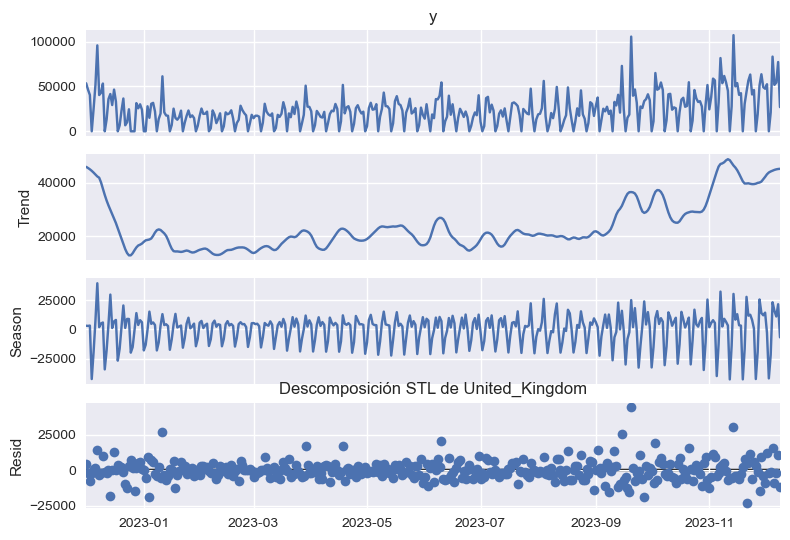

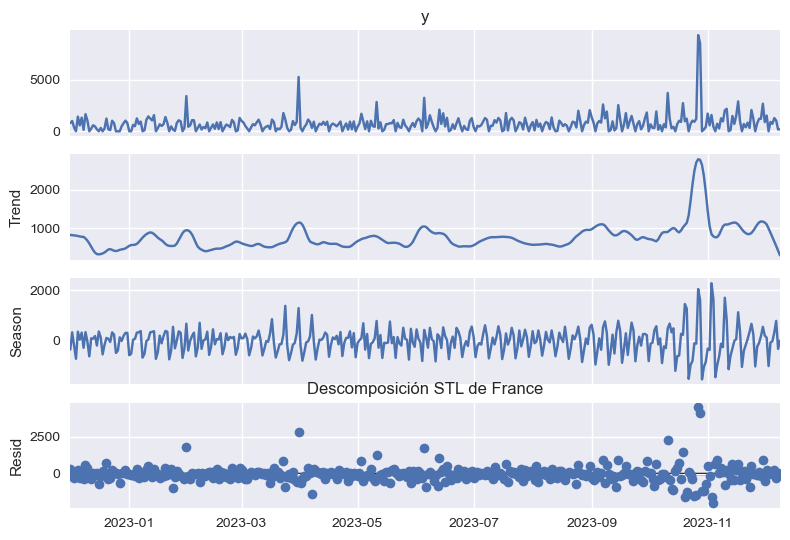

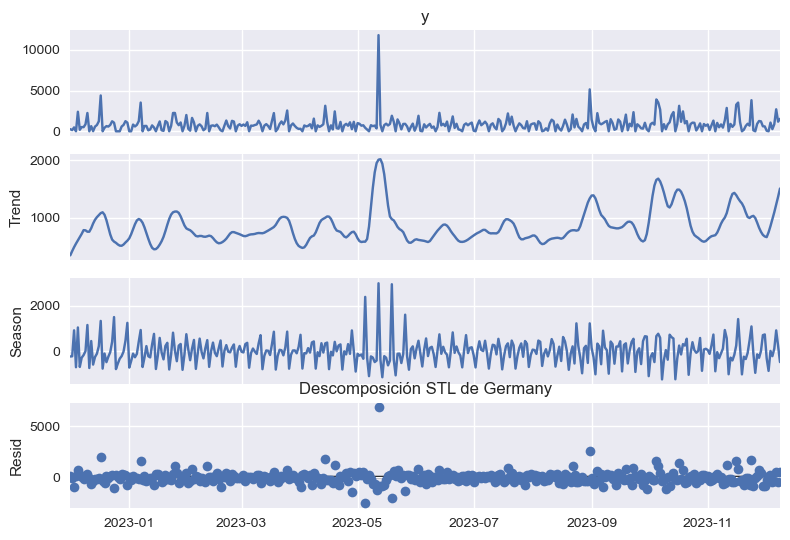

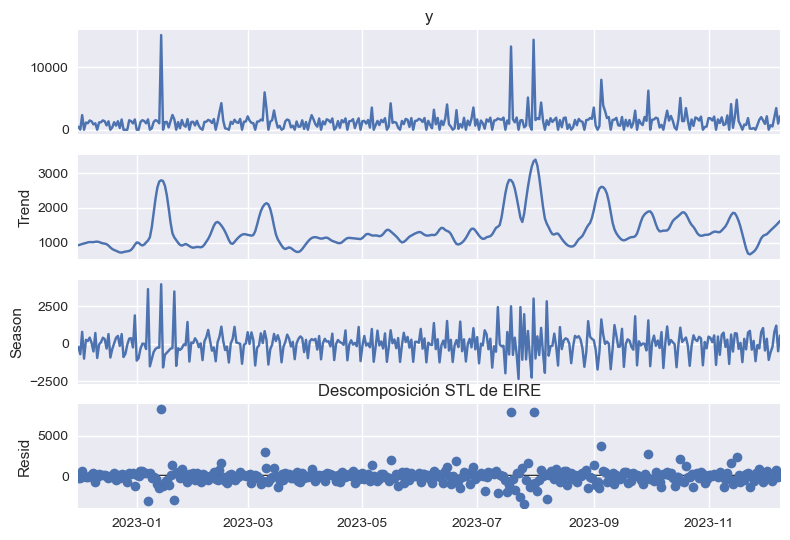

In [51]:
for i in range(num_paises_imput):
    globals()[descs_stl[i]].plot()
    plt.title(f'Descomposición STL de {paises_imput[i]}')
    plt.show()

## Autocorrelacion

Estudiemos la autocorrelación global y la parcial para identificar patrones de estacionalidad

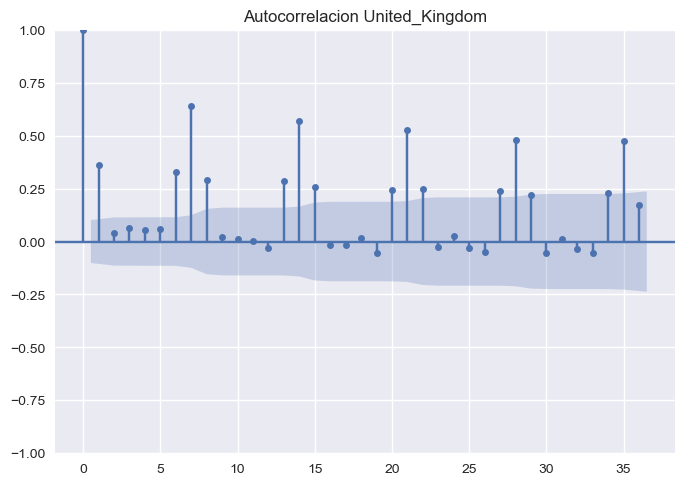

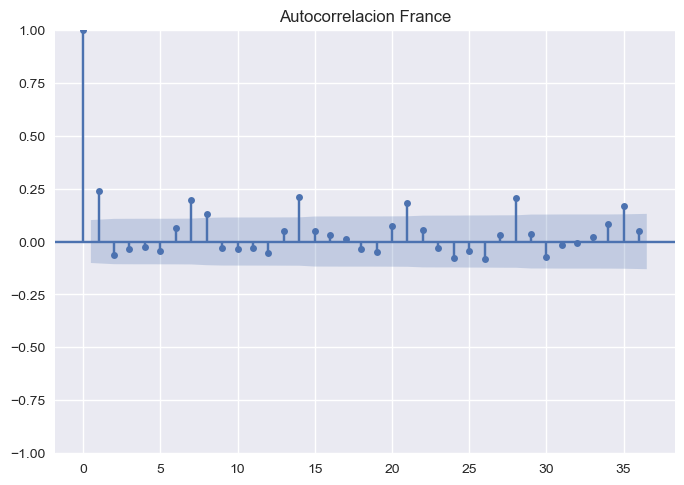

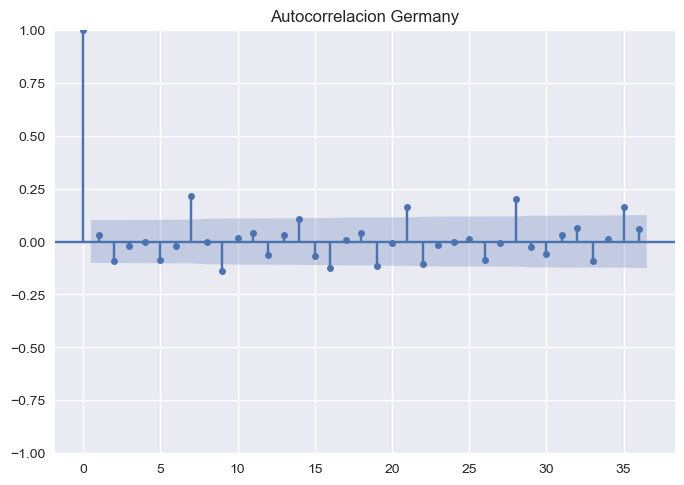

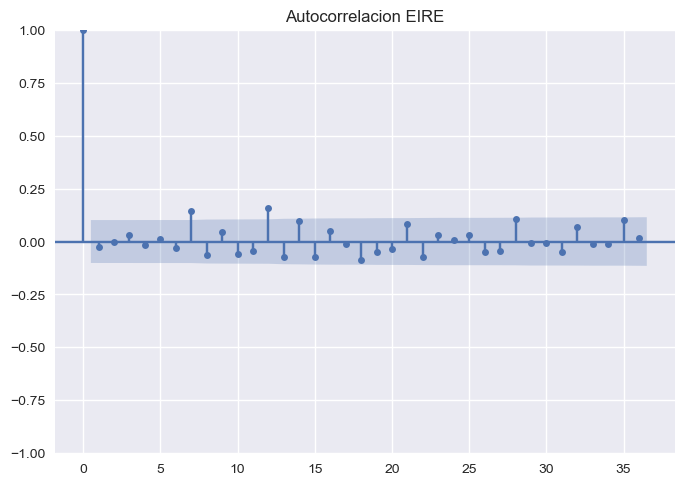

In [52]:
for i in range(num_paises_imput):
    plot_acf(globals()[dfs_imput[i]]['y'], lags = 36)
    plt.title(f'Autocorrelacion {paises_imput[i]}')
    plt.show()


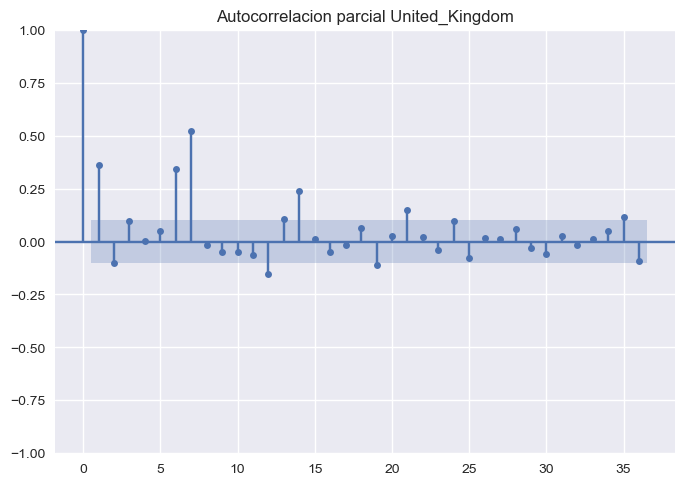

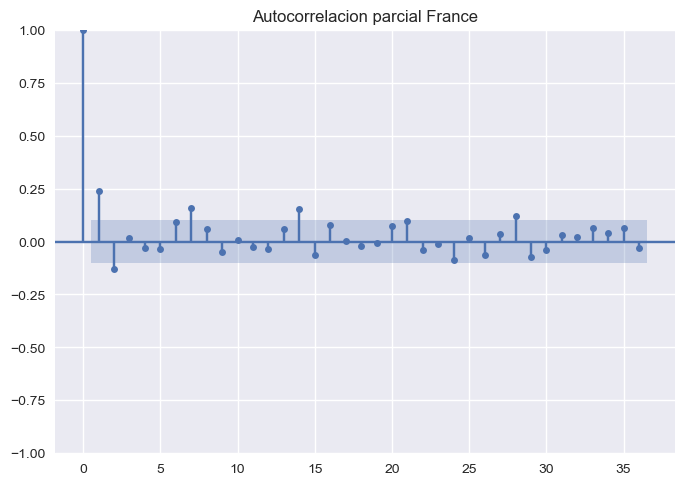

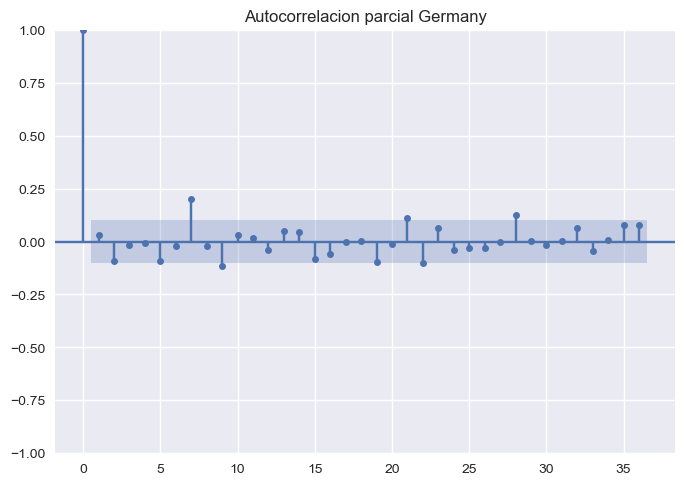

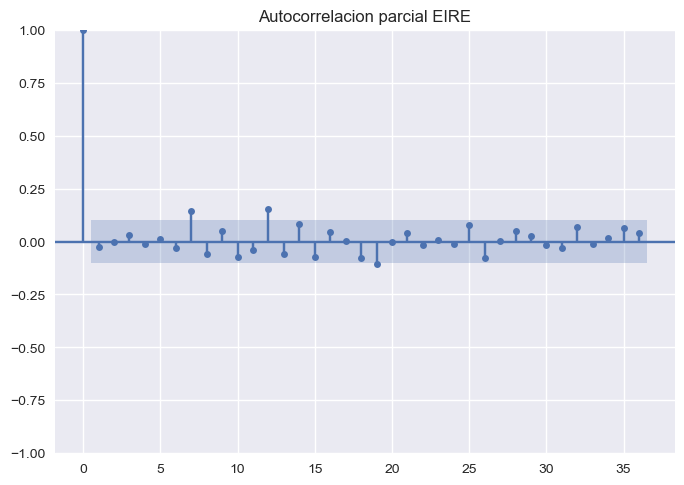

In [53]:
for i in range(num_paises_imput):
    plot_pacf(globals()[dfs_imput[i]]['y'], lags = 36)
    plt.title(f'Autocorrelacion parcial {paises_imput[i]}')
    plt.show()


Para los 4 países, tanto en el gráfico de autocorrelación como  en de autocorrelación parcial, ocurren máximos cada 7 lags,\
lo que nos confirma la existencia de estacionalidad semanal 


## Estacionariedad y tendencia

Voy a pintar la media móvil de 7 días y la de 60 (2 meses) para cada país

In [54]:
# Crear subplots
fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=paises_imput,
    column_widths=[0.5,0.5]  # Ajustar proporción entre histograma y boxplot
)
#de la lista de df con los datos completados con festivos y domingos me quedo con los que he imputado
dfs_comp_imput =dfs_comp[:5]
dfs_comp_imput.remove('df_neth_comp')

# Añadir gráficos
for i in range(num_paises_imput):
    df_temp = globals()[dfs_imput[i]].copy()
    df_temp['media_movil_7'] = df_temp['y'].rolling(window=7, min_periods=7).mean()
    df_temp['media_movil_60'] = df_temp['y'].rolling(window=60, min_periods=15).mean()


    # Valores reales 
    real = go.Scatter(
        x=df_temp['ds'],
        y=df_temp['y'],
        mode='lines',
        line=dict(color='blue'),
        opacity=0.4  
    )

    # Media móvil de 7 días
    media_7 = go.Scatter(
        x=df_temp['ds'],
        y=df_temp['media_movil_7'],
        mode='lines',
        line=dict(color='red'),
        opacity=0.7  
    )
    
    # Valores estimados de aditiva
    media_15 = go.Scatter(
        x=df_temp['ds'],
        y=df_temp['media_movil_60'],
        mode='lines',
        line=dict(color='green'),
        opacity=0.7  
    )
    # Calcular fila y columna para este gráfico
    row = (i // 2) + 1
    col = (i % 2) + 1

    # Añadir el gráfico a la figura
    
    fig.add_trace(real, row=row, col=col)          
    fig.add_trace(media_7, row=row, col=col)   
    fig.add_trace(media_15, row=row, col=col)
    

# Actualizar diseño
fig.update_layout(
    height=200 * num_paises_imput,  # Altura proporcional al número de países
    width=400*num_paises_imput,               # Ancho fijo
    title="Media móvil de 7 y 60 días de los países imputados.     La línea azul es la serie original, la roja la media móvil de 7 días y la verde la de 60 días",
    showlegend=False )
fig.show()          

Se observa que ambas medias, y sobre todo las de los dos meses, se mantienen bastante constantes en todos los países menos Uk. Esto puede suponer que la serie sea estacionaria para todos menos para Uk.\
Confirmemoslo con el test de Dickey-Fuller

In [55]:
for i in range(4):
    result = adfuller(globals()[dfs_imput[i]]['y'])
    if result[1] <0.05:
        print(f'La serie de {paises_imput[i]} es estacionaria, p-valor = {round(result[1],7)}')
    else:
        print(f'La serie de {paises_imput[i]} no es estacionaria, p-valor = {round(result[1],7)}', )


La serie de United_Kingdom no es estacionaria, p-valor = 0.5698902
La serie de France es estacionaria, p-valor = 4e-07
La serie de Germany es estacionaria, p-valor = 0.0
La serie de EIRE es estacionaria, p-valor = 0.0


Efectivamente, las series son estacionarias en todos los países menos en UK.

Por curiosidad voy a ver la estacionariedad para todos los países sin haber imputado nulos ni rellenado con festivos y domingos

In [56]:
for i in range(num_paises):
    result = adfuller(globals()[dfs[i]]['ventas_diarias'])
    if result[1] <0.05:
        print(f'La serie de {paises[i]} es estacionaria, p-valor = {round(result[1],7)}')
    else:
        print(f'La serie de {paises[i]} no es estacionaria, p-valor = {round(result[1],7)}', )


La serie de United_Kingdom no es estacionaria, p-valor = 0.565443
La serie de France es estacionaria, p-valor = 0.0
La serie de Netherlands es estacionaria, p-valor = 0.0
La serie de Germany es estacionaria, p-valor = 0.0
La serie de EIRE es estacionaria, p-valor = 0.0
La serie de Spain es estacionaria, p-valor = 0.0
La serie de Portugal es estacionaria, p-valor = 0.0
La serie de Italy es estacionaria, p-valor = 0.000674
La serie de Belgium es estacionaria, p-valor = 0.0182786
La serie de Sweden es estacionaria, p-valor = 0.0


## Modelos

Defino los tamaños de train-test, asignaré al train un 80% de los datos

In [57]:
train_size = int(len(df_uk_imput)*0.8)
test_size = len(df_uk_imput)-train_size


Por comodidad, a los dataframes que tengo ya imputados (df_pais_imput) les cambio el nombre a df_pais

In [58]:
#Cambio el nombre de los dataframes
for i in range(num_paises_imput):
    globals()[f'df_{paises_abr_imput[i]}'] = globals()[dfs_imput[i]]

# Actualizo los valores de dfs_imput (lista de los df imputados)
dfs_imput = [f'df_{paises_abr_imput[i]}' for i in range(num_paises_imput)]
display(dfs_imput)

['df_uk', 'df_fr', 'df_ger', 'df_eire']

### Prophet

Recuerdo que tengo disponibles las fechas de los festivos en las que asumo que la empresa cerrará. Además también sé que los domingos cierra.\
Creo una función llamada "empresa_cerrada" que recibe una fecha y me dice si la empresa cerrará o no

In [59]:
def empresa_cerrada(ds):
    date = pd.to_datetime(ds)
    if (date in festivos_cerrados.values) or (date.day_name()=='Sunday'):
        return 1
    else:
        return 0

Quiero ahora probar distintos modelos Prophet combinando estacionalidad aditiva o multiplicativa y el uso no del 'efecto' empresa cerrada para ver cual es mejor.\
Para no probarlo en todos los países, lo pruebo en Uk, que es aquel en el que más datos tengo y así el que me resulte el mejor lo usaré para el resto de países.

#### Prophet United Kingdom

In [60]:
# diccionario que tiene los parámetros que voy a usar para cada modelo. Additive y multiplicative hacen referencia al tipo de estacionalidad
#  y True o False si se lleva a cabo o no transformación logarítmica de los valores
modelos_prop = {'aditivo_sin_log': ['additive', False ],
                'aditivo_con_log': ['additive', True ],
                'multiplicativo_sin_log': ['multiplicative', False ],
                'multiplicativo_con_log': ['multiplicative', True ]
}


Separo df_uk en train y test

In [61]:
train_uk = df_uk[:train_size]
test_uk = df_uk[train_size:]
print(f'Tamaño de train-test: {len(train_uk)}-{len(test_uk)}')

Tamaño de train-test: 299-75


In [62]:
#funcion que entrena modelo Pophet con ciertos parámetros
# Recibe el tipo de estacionalidad a probar y si se hace o no la transformación logarítmica
# devuelve el modelo, el dataframe con las fechas a predecir y el dataframe con las predicciones
def entrenar_prop(modelo, train,test, prior_scale = 0.05):
    train['cerrado']=train['ds'].apply(empresa_cerrada)
    train_log = train.copy()
    train_log['y'] = np.log1p(train['y'])

    test['cerrado']=test['ds'].apply(empresa_cerrada)
    test_log = test.copy()
    test_log['y'] = np.log1p(test['y'])
    

    model_prop_temp = Prophet(seasonality_mode=modelos_prop[modelo][0], weekly_seasonality= True, changepoint_prior_scale=prior_scale) 
    if modelos_prop[modelo][1]==True: # si se aplica transformac logaritmica
        model_prop_temp.add_regressor('cerrado', prior_scale=100, mode='multiplicative')
        model_prop_temp.fit(train_log)

        future_prop_temp = model_prop_temp.make_future_dataframe(periods =len(test)+31, freq = 'D') # las fechas a predecir son las de test y 30 días más
        future_prop_temp['cerrado'] = future_prop_temp['ds'].apply(empresa_cerrada)

        forecast_prop_temp = model_prop_temp.predict(future_prop_temp)
        forecast_prop_temp['yhat'] = np.expm1(forecast_prop_temp['yhat']) #deshago la transformación logarítmica
        forecast_prop_temp_clean = forecast_prop_temp[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    else:
        model_prop_temp.add_regressor('cerrado', prior_scale=100, mode='multiplicative')
        model_prop_temp.fit(train)

        future_prop_temp = model_prop_temp.make_future_dataframe(periods =len(test)+31, freq = 'D')
        future_prop_temp['cerrado'] = future_prop_temp['ds'].apply(empresa_cerrada)
        
        forecast_prop_temp = model_prop_temp.predict(future_prop_temp)
        forecast_prop_temp_clean = forecast_prop_temp[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    return model_prop_temp, future_prop_temp, forecast_prop_temp

Ahora mediante validacion cruzada voy a cer cual de los 4 modelos es mejor 

In [63]:
metricas_mae = [] #lista donde voy a guardar el rmse de cada modelo

for modelo in modelos_prop.keys():

    #cross validation
    model_temp = entrenar_prop(modelo, train_uk, test_uk)[0]
    cv_temp = cross_validation(model = model_temp,  initial='185 days', period='15 days', horizon = '30 days' ) #hago validation cruzada con 30 días de horizonte
    if modelos_prop[modelo][1]==True: #si se ha aplicado transf log
        for c in cv_temp.columns[1:-1]:
            cv_temp[c] = np.expm1(cv_temp[c]) #deshago transformacion para que poder comparar todas las métricas
    df_performance_temp = performance_metrics(cv_temp)
    mae_temp = df_performance_temp.describe().T.loc['mae','mean']
    metricas_mae.append(mae_temp)
    
    print(f'\n Métricas para el modelo {modelo}:')
    display(df_performance_temp.describe().T.loc[['rmse','mae'],['mean']]) # Imprimo las métricas RMSE Y MAE
    print('---------------------')


 #me quedo con el modelo con menor mae

print(f'El mejor modelo es  {list(modelos_prop.keys())[metricas_mae.index(sorted(metricas_mae)[0])]}')

13:22:26 - cmdstanpy - INFO - Chain [1] start processing
13:22:27 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]13:22:27 - cmdstanpy - INFO - Chain [1] start processing
13:22:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:01,  3.58it/s]13:22:27 - cmdstanpy - INFO - Chain [1] start processing
13:22:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:00<00:01,  3.65it/s]13:22:27 - cmdstanpy - INFO - Chain [1] start processing
13:22:28 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:00<00:00,  3.38it/s]13:22:28 - cmdstanpy - INFO - Chain [1] start processing
13:22:28 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:01<00:00,  3.41it/s]13:22:28 - cmdstanpy - INFO - Chain [1] start processing
13:22:28 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:01<00:00,  3.41it/s]13:22:28 - cmdstanpy - INFO - Chain [1] start processing
13:


 Métricas para el modelo aditivo_sin_log:


mean
rmse 11195.34
mae   7848.05

13:22:29 - cmdstanpy - INFO - Chain [1] start processing


---------------------


13:22:29 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]13:22:29 - cmdstanpy - INFO - Chain [1] start processing
13:22:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:01,  3.38it/s]13:22:29 - cmdstanpy - INFO - Chain [1] start processing
13:22:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:00<00:01,  3.31it/s]13:22:30 - cmdstanpy - INFO - Chain [1] start processing
13:22:30 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:00<00:00,  3.33it/s]13:22:30 - cmdstanpy - INFO - Chain [1] start processing
13:22:30 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:01<00:00,  3.33it/s]13:22:30 - cmdstanpy - INFO - Chain [1] start processing
13:22:30 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:01<00:00,  3.19it/s]13:22:31 - cmdstanpy - INFO - Chain [1] start processing
13:22:31 - cmdstanpy - INFO - Chain [1] done processing
100%


 Métricas para el modelo aditivo_con_log:


mean
rmse 11787.99
mae   7733.11

---------------------


13:22:31 - cmdstanpy - INFO - Chain [1] start processing
13:22:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]13:22:32 - cmdstanpy - INFO - Chain [1] start processing
13:22:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:01,  2.82it/s]13:22:32 - cmdstanpy - INFO - Chain [1] start processing
13:22:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:00<00:01,  3.25it/s]13:22:32 - cmdstanpy - INFO - Chain [1] start processing
13:22:32 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:00<00:00,  3.02it/s]13:22:33 - cmdstanpy - INFO - Chain [1] start processing
13:22:33 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:01<00:00,  3.15it/s]13:22:33 - cmdstanpy - INFO - Chain [1] start processing
13:22:33 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:01<00:00,  3.22it/s]13:22:33 - cmdstanpy - INFO - Chain [1] start processing
13:


 Métricas para el modelo multiplicativo_sin_log:


mean
rmse 11375.51
mae   7915.19

---------------------


13:22:34 - cmdstanpy - INFO - Chain [1] start processing
13:22:34 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]13:22:34 - cmdstanpy - INFO - Chain [1] start processing
13:22:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:01,  2.78it/s]13:22:34 - cmdstanpy - INFO - Chain [1] start processing
13:22:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:00<00:01,  2.74it/s]13:22:35 - cmdstanpy - INFO - Chain [1] start processing
13:22:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  2.51it/s]13:22:35 - cmdstanpy - INFO - Chain [1] start processing
13:22:35 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:01<00:00,  2.38it/s]13:22:36 - cmdstanpy - INFO - Chain [1] start processing
13:22:36 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:02<00:00,  2.33it/s]13:22:36 - cmdstanpy - INFO - Chain [1] start processing
13:


 Métricas para el modelo multiplicativo_con_log:


mean
rmse 11799.09
mae   7728.76

---------------------
El mejor modelo es  multiplicativo_con_log


In [64]:
# Defino el que ha sido el mejor modelo
prop_best= 'multiplicativo_con_log' 

In [65]:
# Defino el mejor modelo para Uk:
[model_prop_uk, future_prop_uk, forecast_prop_uk] = entrenar_prop(prop_best, train_uk, test_uk)

forecast_prop_uk_clean = forecast_prop_uk[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

13:22:37 - cmdstanpy - INFO - Chain [1] start processing
13:22:37 - cmdstanpy - INFO - Chain [1] done processing


In [66]:
# Pinto la serie original junto con la predicción
fig_prop_uk = px.line(pd.concat([df_uk.set_index('ds')['y'], forecast_prop_uk_clean.set_index('ds')['yhat']], axis = 1)\
        , title = f'Modelo multiplicartivo con transformación logarítmica para {paises_imput[0]}')
fig_prop_uk.add_vline(x=test_uk.ds.iloc[0].strftime('%Y-%m-%d'), line=dict( dash='dash', width=2), name ='entrenamiento-test') #linea vertical que me indica donde empieza el test
fig_prop_uk.show()

In [67]:
# Quiero separar el forecast_prop_uk en train y test para calcular los errores en train y test
forecast_prop_uk_train = forecast_prop_uk_clean[:train_size]
forecast_prop_uk_test = forecast_prop_uk_clean[train_size:train_size+test_size]

In [68]:
# Calculo los errores para las fechas en los que la empresa esta abierta, e.d., y es distinto de cero
df_temp1=errores(train_uk.query('y != 0')['y'], forecast_prop_uk_train[forecast_prop_uk_train.ds.isin(train_uk.query('y != 0').ds)]['yhat'])
df_temp2=errores(test_uk.query('y != 0')['y'], forecast_prop_uk_test[forecast_prop_uk_test.ds.isin(test_uk.query('y != 0').ds)]['yhat'])
error_prop_uk = pd.concat([df_temp1,df_temp2], axis=1)
error_prop_uk.columns = ['Errores Train','Errores Test']
display(error_prop_uk)


Errores Train  Errores Test
MAE          6663.03      12381.34
RMSE        10434.35      17148.82
MAPE            0.30          0.27
SMAPE           0.28          0.30

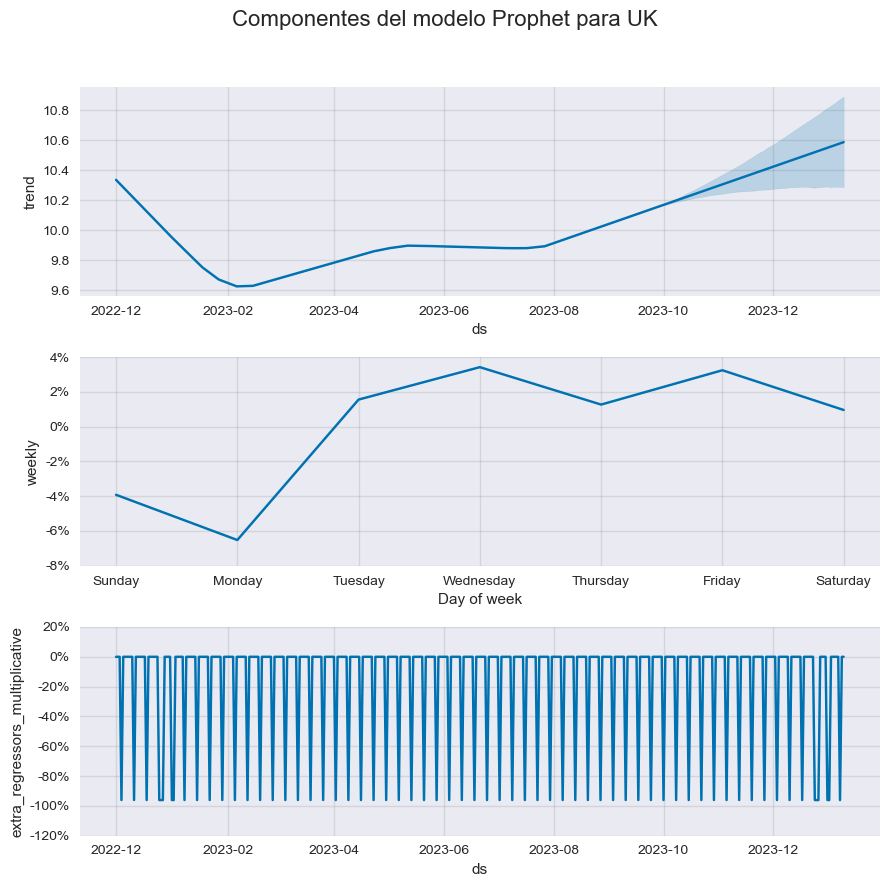

In [69]:
#descomposicion resultados
desc_prop_uk = plot_components(model_prop_uk, forecast_prop_uk)
desc_prop_uk.suptitle("Componentes del modelo Prophet para UK", fontsize=16)
desc_prop_uk.tight_layout(rect=[0, 0, 1, 0.95])


#### Prophet Resto de paises

Para los 3 países que me quedan voy a usar el modelo multiplicativo con transformación logarítmica, ya que es el mejor para Uk.\
Voy a hacer lo mismo ue hecho en Uk pare el resto de países.

In [70]:
#Lo primero es separar los datos en train y test
for i in range(3):
    globals()[f'train_{paises_abr_imput[i+1]}'] = globals()[dfs_imput[i+1]][:train_size]
    globals()[f'test_{paises_abr_imput[i+1]}'] = globals()[dfs_imput[i+1]][train_size:]
    print(f'Tamaño de train-test para {paises_imput[i+1]}: {len(globals()[f"train_{paises_abr_imput[i+1]}"])}-{len(globals()[f"test_{paises_abr_imput[i+1]}"])}')

#hago una lista con los train y otra con los test de los paises 
trains_prop = [f'train_{paises_abr_imput[i]}' for i in range(num_paises_imput)]  #añado también el de Uk
tests_prop = [f'test_{paises_abr_imput[i]}' for i in range(num_paises_imput)]
display(trains_prop)
display(tests_prop)

Tamaño de train-test para France: 299-75
Tamaño de train-test para Germany: 299-75
Tamaño de train-test para EIRE: 299-75


['train_uk', 'train_fr', 'train_ger', 'train_eire']

['test_uk', 'test_fr', 'test_ger', 'test_eire']

In [71]:
#Defino los mejores modelos para los paises
for i in range(3):
    [globals()[f'model_prop_{paises_abr_imput[i+1]}'], globals()[f'future_prop_{paises_abr_imput[i+1]}'],\
     globals()[f'forecast_prop_{paises_abr_imput[i+1]}']] = entrenar_prop(prop_best, globals()[trains_prop[i+1]], globals()[tests_prop[i+1]])

    globals()[f'forecast_prop_{paises_abr_imput[i+1]}_clean'] = globals()[f'forecast_prop_{paises_abr_imput[i+1]}'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Me guardo los modelos, los future_prop, los forecast_prop y los forecast_prop_clean en listas
models_prop = [f'model_prop_{paises_abr_imput[i]}' for i in range(num_paises_imput)]
futures_prop = [f'future_prop_{paises_abr_imput[i]}' for i in range(num_paises_imput)]
forecasts_prop = [f'forecast_prop_{paises_abr_imput[i]}' for i in range(num_paises_imput)]
forecasts_prop_clean = [f'forecast_prop_{paises_abr_imput[i]}_clean' for i in range(num_paises_imput)]


13:22:40 - cmdstanpy - INFO - Chain [1] start processing
13:22:41 - cmdstanpy - INFO - Chain [1] done processing
13:22:41 - cmdstanpy - INFO - Chain [1] start processing
13:22:41 - cmdstanpy - INFO - Chain [1] done processing
13:22:42 - cmdstanpy - INFO - Chain [1] start processing
13:22:42 - cmdstanpy - INFO - Chain [1] done processing


In [72]:
# Pinto las series originales junto con las predicciones
figs_prop = ['fig_prop_uk'] # lista donde me guardo los gráficos de los 4 países
for i in range(3):
    figs_prop.append(f'fig_prop_{paises_abr_imput[i+1]}')
    globals()[figs_prop[i+1]] = px.line(pd.concat([globals()[dfs_imput[i+1]].set_index('ds')['y'],\
             globals()[forecasts_prop_clean[i+1]].set_index('ds')['yhat']], axis = 1), title = f'Modelo multiplicativo con transformación logarítmica para {paises_imput[i+1]}')
    globals()[figs_prop[i+1]].add_vline(x=globals()[tests_prop[i+1]].ds.iloc[0].strftime('%Y-%m-%d'), line=dict( dash='dash', width=2), name ='entrenamiento-test') #linea vertical que me indica donde empieza el test
    globals()[figs_prop[i+1]].show()

In [73]:
# Quiero separar los forecast_prop en train y test para calcular los errores en train y test

forecasts_prop_trains = ['forecast_prop_uk_train']  #listas donde guardo los forecast_train y forecast_test
forecasts_prop_tests = ['forecast_prop_uk_test']
for i in range(3):
    forecasts_prop_trains.append(f'forecast_prop_{paises_abr_imput[1:][i]}_train')
    forecasts_prop_tests.append(f'forecast_prop_{paises_abr_imput[1:][i]}_test')
    globals()[forecasts_prop_trains[i+1]] = globals()[forecasts_prop_clean[1:][i]][:train_size]
    globals()[forecasts_prop_tests[i+1]] = globals()[forecasts_prop_clean[1:][i]][train_size:train_size+test_size]

In [74]:
# Calculo los errores en el resto de paises para las fechas en los que la empresa esta abierta
for i in range(3):
    df_temp1 = errores(globals()[trains_prop[i+1]].query('y != 0')['y'],\
             globals()[forecasts_prop_trains[i+1]][globals()[forecasts_prop_trains[i+1]].ds.isin(globals()[trains_prop[i+1]].query('y != 0').ds)]['yhat'])
    df_temp2 = errores(globals()[tests_prop[i+1]].query('y != 0')['y'],\
             globals()[forecasts_prop_tests[i+1]][globals()[forecasts_prop_tests[i+1]].ds.isin(globals()[tests_prop[i+1]].query('y != 0').ds)]['yhat'])
    
    globals()[f'error_prop_{paises_abr_imput[i+1]}'] = pd.concat([df_temp1,df_temp2], axis=1)
    globals()[f'error_prop_{paises_abr_imput[i+1]}'].columns = ['Errores Train','Errores Test']
    print(f'Errores de train y test para {paises_imput[i+1]}')
    display(globals()[f'error_prop_{paises_abr_imput[i+1]}'])

errores_prop = [f'error_prop_{paises_abr_imput[i]}' for i in range(num_paises_imput)] #lista con los errores de los 4 paises

Errores de train y test para France


Errores Train  Errores Test
MAE           352.51        781.05
RMSE          575.94       1580.35
MAPE            1.23          0.87
SMAPE           0.48          0.63

Errores de train y test para Germany


Errores Train  Errores Test
MAE           453.70        660.40
RMSE          954.60       1023.68
MAPE            1.04          0.97
SMAPE           0.50          0.59

Errores de train y test para EIRE


Errores Train  Errores Test
MAE           728.41        757.90
RMSE         1701.02       1138.73
MAPE            0.81          0.89
SMAPE           0.46          0.49

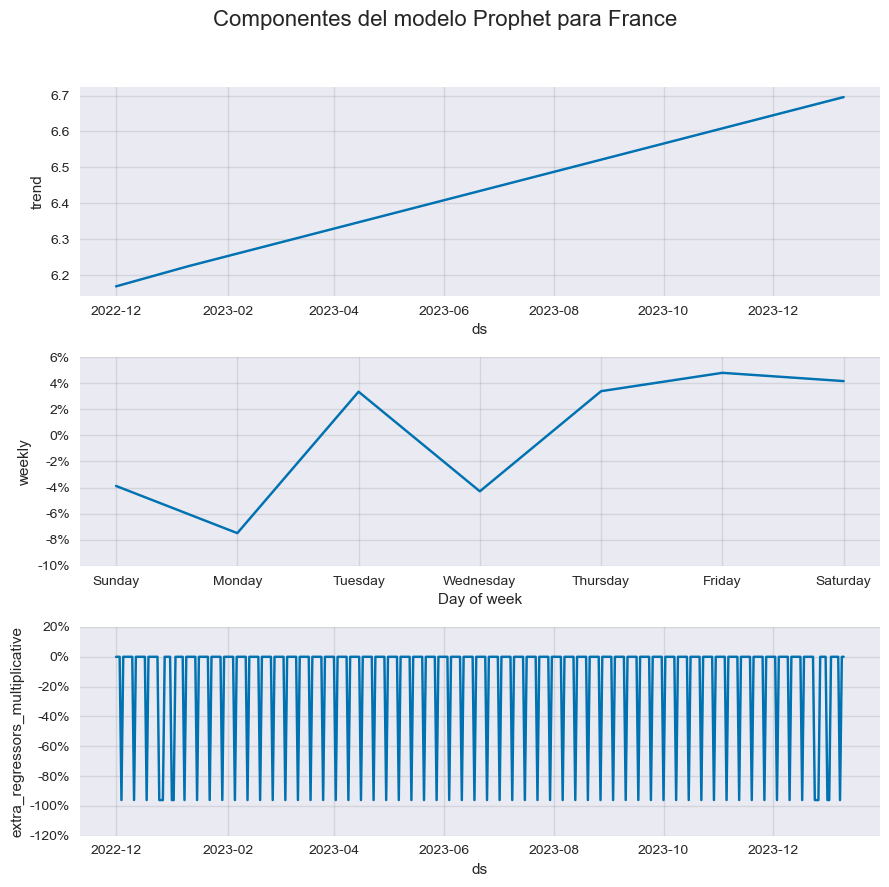

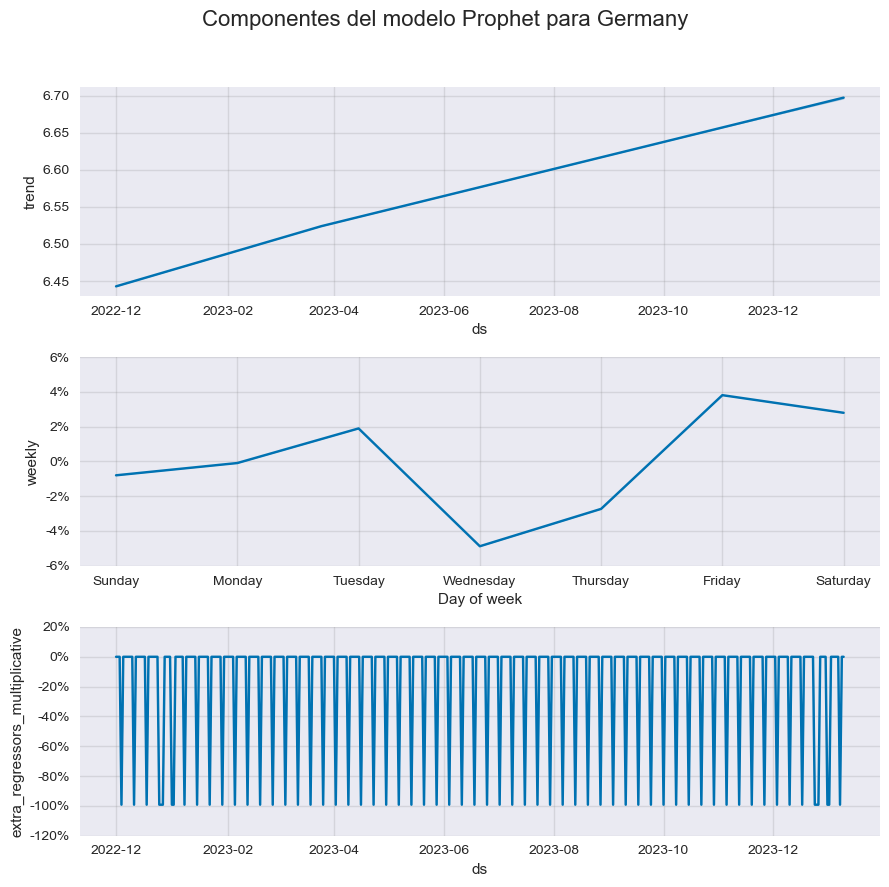

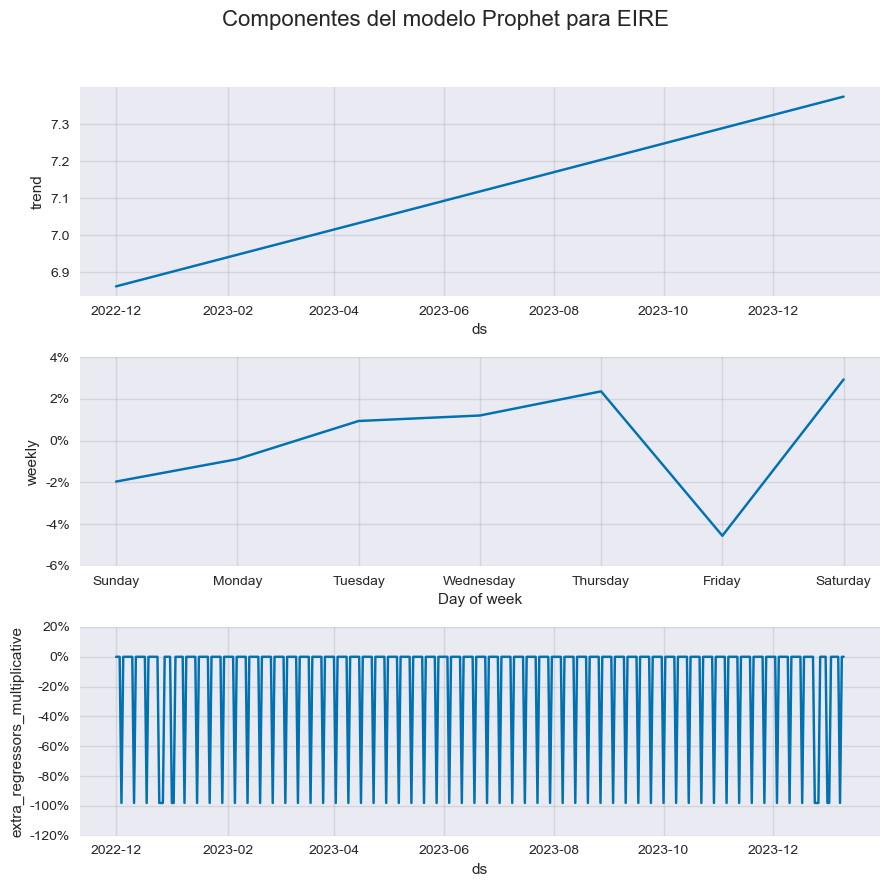

In [75]:
#descomposicion resultados
descs_prop = ['desc_prop_uk'] #lista con las descomposiciones prophet
for i in range(3):
    descs_prop.append(f'desc_prop_{paises_abr_imput[i+1]}')
    globals()[descs_prop[i+1]] = plot_components(globals()[models_prop[i+1]], globals()[forecasts_prop[i+1]])
    globals()[descs_prop[i+1]].suptitle(f"Componentes del modelo Prophet para {paises_imput[i+1]}", fontsize=16)
    globals()[descs_prop[i+1]].tight_layout(rect=[0, 0, 1, 0.95])



#### Prophet mes futuro


Una vez ya he elegido mi mejor modelo con la particion train-test (80%-20%), a la hora de predecir un mes futuro del cual no tengo datos,\
voy a reentrenar los modelos pero entrenándolos con todos los datos,es decir, mi set_size será 0

In [76]:
test_size_pred = 0
train_size_pred = len(df_uk)-test_size_pred

In [77]:
#Hago las nuevas particiones train-test
for i in range(num_paises_imput):
    globals()[f'train_{paises_abr_imput[i]}_pred'] = globals()[dfs_imput[i]][:train_size_pred]
    globals()[f'test_{paises_abr_imput[i]}_pred'] = globals()[dfs_imput[i]][train_size_pred:]
    print(f'Tamaño de train-test para {paises_imput[i]}: {len(globals()[f"train_{paises_abr_imput[i]}_pred"])}-{len(globals()[f"test_{paises_abr_imput[i]}_pred"])}')

#hago una lista con los train y otra con los test de los paises 
trains_prop_pred = [f'train_{paises_abr_imput[i]}_pred' for i in range(num_paises_imput)]  #añado también el de Uk
tests_prop_pred = [f'test_{paises_abr_imput[i]}_pred' for i in range(num_paises_imput)]
display(trains_prop_pred)
display(tests_prop_pred)

Tamaño de train-test para United_Kingdom: 374-0
Tamaño de train-test para France: 374-0
Tamaño de train-test para Germany: 374-0
Tamaño de train-test para EIRE: 374-0


['train_uk_pred', 'train_fr_pred', 'train_ger_pred', 'train_eire_pred']

['test_uk_pred', 'test_fr_pred', 'test_ger_pred', 'test_eire_pred']

In [78]:
# Reentreno los modelos
for i in range(num_paises_imput):
    [globals()[f'model_prop_{paises_abr_imput[i]}_pred'], globals()[f'future_prop_{paises_abr_imput[i]}_pred'],\
     globals()[f'forecast_prop_{paises_abr_imput[i]}_pred']] = entrenar_prop(prop_best, globals()[trains_prop_pred[i]], globals()[tests_prop_pred[i]])

    globals()[f'forecast_prop_{paises_abr_imput[i]}_clean_pred'] = globals()[f'forecast_prop_{paises_abr_imput[i]}_pred'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Me guardo los modelos reentrenados, los future_prop, los forecast_prop y los forecast_prop_clean en listas
models_prop_pred = [f'model_prop_{paises_abr_imput[i]}_pred' for i in range(num_paises_imput)]
futures_prop_pred = [f'future_prop_{paises_abr_imput[i]}_pred' for i in range(num_paises_imput)]
forecasts_prop_pred = [f'forecast_prop_{paises_abr_imput[i]}_pred' for i in range(num_paises_imput)]
forecasts_prop_clean_pred = [f'forecast_prop_{paises_abr_imput[i]}_clean_pred' for i in range(num_paises_imput)]


13:22:48 - cmdstanpy - INFO - Chain [1] start processing
13:22:48 - cmdstanpy - INFO - Chain [1] done processing
13:22:49 - cmdstanpy - INFO - Chain [1] start processing
13:22:49 - cmdstanpy - INFO - Chain [1] done processing
13:22:49 - cmdstanpy - INFO - Chain [1] start processing
13:22:49 - cmdstanpy - INFO - Chain [1] done processing
13:22:50 - cmdstanpy - INFO - Chain [1] start processing
13:22:50 - cmdstanpy - INFO - Chain [1] done processing


In [79]:
# Pinto las series originales junto con las predicciones
figs_prop_pred = [] # lista donde me guardo los gráficos de los 4 países
for i in range(num_paises_imput):
    figs_prop_pred.append(f'fig_prop_{paises_abr_imput[i]}_pred')
    globals()[figs_prop_pred[i]] = px.line(pd.concat([globals()[dfs_imput[i]].set_index('ds')['y'],\
             globals()[forecasts_prop_clean_pred[i]].set_index('ds')['yhat']], axis = 1), title = f'Modelo multiplicativo con transformación logarítmica para {paises_imput[i]}')
    globals()[figs_prop_pred[i]].add_vline(x=globals()[trains_prop_pred[i]].ds.iloc[-1].strftime('%Y-%m-%d'), line=dict( dash='dash', width=2), name ='entrenamiento-test') #linea vertical que me indica donde empieza el test
    globals()[figs_prop_pred[i]].show()

Hay una gran diferencia en las predicciones futuras de los distintos países.\
 Para UK, que vimos que era una serie estacionaria, en los valores de la predicción se ve una tendencia ascendente clara. Puede ser que esa subida del final de año\
  sea por el blackfriday en noviembre y las navidades en diciembre. Es decir, que luego en enero los valores deberían bajar. En el gráfico se muestra que la diferencia entre enero de 2023 y de 2024 es muy grande. Voy a rehacer la predicción de Uk usando tendencia logarítmica y definiendo como límite superior el máximo histórico ocurrido.\
   De todos modos, al no tener datos de más años disponibles, todo esto que digo son suposiciones sin fundamento.

   En cambio para el resto de países, que eran series estacionarias, los valores predecidos son parecidos a los del año pasado, así que esas predicciones las dejo como están

In [80]:
# vuelvo entrenar el modelo para Uk con tendencia logarítmica
train_uk_pred['cerrado']=train_uk_pred['ds'].apply(empresa_cerrada)
train_uk_pred['cap'] = train_uk_pred['y'].max()
train_uk_pred['floor'] = 0
model_prop_uk_pred = Prophet(seasonality_mode='multiplicative', weekly_seasonality= True,growth='logistic')
model_prop_uk_pred.add_regressor('cerrado', prior_scale=100, mode='multiplicative')
model_prop_uk_pred.fit(train_uk_pred)

future_prop_uk_pred = model_prop_uk_pred.make_future_dataframe(periods =len(test_uk_pred)+31, freq = 'D')
future_prop_uk_pred['cerrado'] = future_prop_uk_pred['ds'].apply(empresa_cerrada)
future_prop_uk_pred['cap'] = train_uk_pred['y'].max()*1.1
future_prop_uk_pred['floor'] = 0

forecast_prop_uk_pred = model_prop_uk_pred.predict(future_prop_uk_pred)
forecast_prop_uk_clean_pred = forecast_prop_uk_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

13:22:51 - cmdstanpy - INFO - Chain [1] start processing
13:22:51 - cmdstanpy - INFO - Chain [1] done processing


In [81]:
# Vuelvo a pintar la serie para UK
fig_prop_uk_pred = px.line(pd.concat([df_uk.set_index('ds')['y'], forecast_prop_uk_pred.set_index('ds')['yhat']], axis = 1)\
        , title = f'Modelo multiplicartivo con transformación logarítmica para {paises_imput[0]}')
fig_prop_uk_pred.add_vline(x=train_uk_pred.ds.iloc[-1].strftime('%Y-%m-%d'), line=dict( dash='dash', width=2), name ='entrenamiento-test') 
fig_prop_uk_pred.show()

Ahora ya la subida de fin  de año queda menos pronunciada.

Solo quedaría corregir tanto para Uk como para los demás paises, asignar el valor 0  a cuando la empresa está cerrada, ya que para algunos\
 días el valor es ligeramente mayor que cero o incluso negativo

In [82]:
for i in range(num_paises_imput):
    indice_temp = globals()[futures_prop_pred[i]].query('cerrado==1').index 
    globals()[forecasts_prop_pred[i]].loc[indice_temp, 'yhat']=0  #cambio a 0 los valores de yhat cuando la empresa esta cerrada
    globals()[forecasts_prop_clean_pred[i]] = globals()[forecasts_prop_pred[i]][['ds', 'yhat', 'yhat_lower', 'yhat_upper']] #actualizo los forecast_prop_clean_pred

    # las vuelvo a pintar
    globals()[figs_prop_pred[i]] = px.line(pd.concat([globals()[dfs_imput[i]].set_index('ds')['y'],\
             globals()[forecasts_prop_clean_pred[i]].set_index('ds')['yhat']], axis = 1), title = f'Modelo multiplicativo con transformación logarítmica para {paises_imput[i]}')
    globals()[figs_prop_pred[i]].add_vline(x=globals()[trains_prop_pred[i]].ds.iloc[-1].strftime('%Y-%m-%d'), line=dict( dash='dash', width=2), name ='entrenamiento-test') #linea vertical que me indica donde empieza el test
    globals()[figs_prop_pred[i]].show()

En conclusión, los modelos se ajustan bastante bien, a excepción de ciertos días puntuales.\
Como ya he mencionado anteiormente, en estos días pudo haber ofertas, puede ser cercanía a navidad...\
Vuelvo al insistir que al tener solo un año, y no saber la existencia de posibles ofertas, no podemos predecir esos picos puntuales.

Ahora voy a probar otro modelo, usando el mismo procedimiento que con Prophet, entrenando primero con un 80-20 y luego con todos los datos

### Catboost

Voy a crear un dataset para cada país, copiando los que ya tenía (con la columna ds e y).\
A estos datasets les añadiré mása información y pondré 31 días más al final que es el mes futuro que quiero predecir

In [83]:
#fechas de 31 días siguientes al ultimo dato disponible
nuevo_mes = pd.date_range(start=fecha_max, periods=32, freq='D')[1:]

#Creo dataframe con esas nuevas fechas,a la columna y le asigno el valor nulo
df_nuevo_mes =pd.DataFrame({'ds': nuevo_mes, 'y': np.nan})

# Creo un df nuevo para cada país (df_pais_cat)
dfs_cat = []
for i in range(num_paises_imput):
    dfs_cat.append(f'df_{paises_abr_imput[i]}_cat')
    globals()[dfs_cat[i]] = globals()[dfs_imput[i]].copy() #copio los datasets en los que tenía 2 columnas (ds,y)
    globals()[dfs_cat[i]] = pd.concat([globals()[dfs_cat[i]], df_nuevo_mes], ignore_index=True) #concateno los datasets con el nuevo mes
    globals()[dfs_cat[i]]['year'] = globals()[dfs_cat[i]]['ds'].dt.year
    globals()[dfs_cat[i]]['month'] = globals()[dfs_cat[i]]['ds'].dt.month
    globals()[dfs_cat[i]]['day_of_week'] = globals()[dfs_cat[i]]['ds'].dt.day_of_week
    globals()[dfs_cat[i]]['trimestre'] = globals()[dfs_cat[i]]['ds'].dt.quarter
    globals()[dfs_cat[i]]['cerrado'] = globals()[dfs_cat[i]].ds.apply(empresa_cerrada)
    globals()[dfs_cat[i]]['lag_7'] = globals()[dfs_cat[i]]['y'].shift(7)
    globals()[dfs_cat[i]]['lag_14'] = globals()[dfs_cat[i]]['y'].shift(14)
    print(f'Para {paises_imput[i]}:')
    display(globals()[dfs_cat[i]].head(1))
    display(globals()[dfs_cat[i]].tail(1))

display(dfs_cat)

Para United_Kingdom:


ds        y  year  month  day_of_week  trimestre  cerrado  lag_7  \
0 2022-12-01 53520.58  2022     12            3          4        0    NaN   

   lag_14  
0     NaN

ds   y  year  month  day_of_week  trimestre  cerrado  lag_7  \
404 2024-01-09 NaN  2024      1            1          1        0    NaN   

     lag_14  
404     NaN

Para France:


ds      y  year  month  day_of_week  trimestre  cerrado  lag_7  \
0 2022-12-01 792.90  2022     12            3          4        0    NaN   

   lag_14  
0     NaN

ds   y  year  month  day_of_week  trimestre  cerrado  lag_7  \
404 2024-01-09 NaN  2024      1            1          1        0    NaN   

     lag_14  
404     NaN

Para Germany:


ds      y  year  month  day_of_week  trimestre  cerrado  lag_7  \
0 2022-12-01 261.48  2022     12            3          4        0    NaN   

   lag_14  
0     NaN

ds   y  year  month  day_of_week  trimestre  cerrado  lag_7  \
404 2024-01-09 NaN  2024      1            1          1        0    NaN   

     lag_14  
404     NaN

Para EIRE:


ds      y  year  month  day_of_week  trimestre  cerrado  lag_7  \
0 2022-12-01 483.08  2022     12            3          4        0    NaN   

   lag_14  
0     NaN

ds   y  year  month  day_of_week  trimestre  cerrado  lag_7  \
404 2024-01-09 NaN  2024      1            1          1        0    NaN   

     lag_14  
404     NaN

['df_uk_cat', 'df_fr_cat', 'df_ger_cat', 'df_eire_cat']

In [84]:
# defino las columnas de los datos y la columna con los valores a predecir
columns_X = ['year', 'month', 'day_of_week','trimestre','cerrado','lag_7','lag_14']
columns_y = 'y'

# defino las listas donde voy a guardar los train_X, train_y, test_X ,test_y y el nuevo_mes_X de cada país
trains_cat_X = [f'train_{paises_abr_imput[i]}_cat_X' for i in range(num_paises_imput)]
trains_cat_y = [f'train_{paises_abr_imput[i]}_cat_y' for i in range(num_paises_imput)]
tests_cat_X = [f'test_{paises_abr_imput[i]}_cat_X' for i in range(num_paises_imput)]
tests_cat_y = [f'test_{paises_abr_imput[i]}_cat_y' for i in range(num_paises_imput)]
nuevos_meses_X = [f'nuevo_mes_{paises_abr_imput[i]}_X' for i in range(num_paises_imput)]

# Separo los datos en train_X, train_y, test_X y test_y para cada país
for i in range(num_paises_imput):
    globals()[trains_cat_X[i]] = globals()[dfs_cat[i]][columns_X][:train_size]
    globals()[trains_cat_y[i]] = globals()[dfs_cat[i]][columns_y][:train_size]
    globals()[tests_cat_X[i]] = globals()[dfs_cat[i]][columns_X][train_size:train_size+test_size]
    globals()[tests_cat_y[i]] = globals()[dfs_cat[i]][columns_y][train_size:train_size+test_size]
    globals()[nuevos_meses_X[i]] = globals()[dfs_cat[i]][columns_X][train_size+test_size:] #el nuevo mes

    print(f'Tamaño de train-test para {paises_imput[i]}: {len(globals()[trains_cat_X[i]])}-{len(globals()[tests_cat_X[i]])}')   

Tamaño de train-test para United_Kingdom: 299-75
Tamaño de train-test para France: 299-75
Tamaño de train-test para Germany: 299-75
Tamaño de train-test para EIRE: 299-75


 #### Optimización de Hiperparámetros

In [85]:
"""
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


tscv = TimeSeriesSplit(n_splits=5)
# Definir la grilla de parámetros
param_grid = {
    'depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100,300,500,1000]  # Iterations equivalen a n_estimators
}

# Crear el modelo y el GridSearchCV
cat_boost = GridSearchCV(
    estimator=CatBoostRegressor(silent=True),  # Modelo base
    param_grid=param_grid,  # Grilla de parámetros
    cv=tscv,  # Número de folds para cross-validation
    
)
mejores_parametros_cat = [] #lista donde guardo los mejores parámetros de cada país
for i in range(num_paises_imput):
    cat_boost.fit(globals()[trains_cat_X[i]], globals()[trains_cat_y[i]])
    globals()[f'best_params_{paises_abr_imput[i]}'] = cat_boost.best_params_
    print(f'Para {paises_imput[i]}:')
    print(f'Mejores parámetros: {globals()[f"best_params_{paises_abr_imput[i]}"]}')
    print('------------------------------------')
    mejores_parametros_cat.append(globals()[f'best_params_{paises_abr_imput[i]}'])
    """



'\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.model_selection import TimeSeriesSplit\n\n\ntscv = TimeSeriesSplit(n_splits=5)\n# Definir la grilla de parámetros\nparam_grid = {\n    \'depth\': [3, 4, 5, 6],\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'iterations\': [100,300,500,1000]  # Iterations equivalen a n_estimators\n}\n\n# Crear el modelo y el GridSearchCV\ncat_boost = GridSearchCV(\n    estimator=CatBoostRegressor(silent=True),  # Modelo base\n    param_grid=param_grid,  # Grilla de parámetros\n    cv=tscv,  # Número de folds para cross-validation\n    \n)\nmejores_parametros_cat = [] #lista donde guardo los mejores parámetros de cada país\nfor i in range(num_paises_imput):\n    cat_boost.fit(globals()[trains_cat_X[i]], globals()[trains_cat_y[i]])\n    globals()[f\'best_params_{paises_abr_imput[i]}\'] = cat_boost.best_params_\n    print(f\'Para {paises_imput[i]}:\')\n    print(f\'Mejores parámetros: {globals()[f"best_params_{paises_abr_imput[i]}"]}\')\n 

Para no tener que ejecutar este código más veces, ya que tarda, voy a guardar los resultados de los mejores parámetros en formato json y así los cargo cuando los necesite

In [86]:
"""
import json

# Guardar
with open("mejores_parametros_cat.json", "w") as file:
    json.dump(mejores_parametros_cat, file)
"""

'\nimport json\n\n# Guardar\nwith open("mejores_parametros_cat.json", "w") as file:\n    json.dump(mejores_parametros_cat, file)\n'

In [87]:
import json
#  Cargo los mejores parámetros de cada país
with open("mejores_parametros_cat.json", "r") as file:
    mejores_parametros_cat = json.load(file)
    
display(mejores_parametros_cat)

[{'depth': 3, 'iterations': 100, 'learning_rate': 0.05},
 {'depth': 3, 'iterations': 300, 'learning_rate': 0.01},
 {'depth': 6, 'iterations': 300, 'learning_rate': 0.01},
 {'depth': 4, 'iterations': 100, 'learning_rate': 0.01}]

#### Catboost para los 4 países

In [88]:
#Defino para cada páis el modelo con los mejores parámetros
for i in range(num_paises_imput):
    globals()[f'model_cat_{paises_abr_imput[i]}'] = CatBoostRegressor(**mejores_parametros_cat[i], verbose=0)
models_cat = [f'model_cat_{paises_abr_imput[i]}' for i in range(num_paises_imput)]

Ahora voy a definir una función que recibe el modelo y los datasets: train_pais_cat_X, train_pais_cat_y, test_pais_cat_X y nuevo_mes_pais_X.\
Me devuelve las predicciones de las fechas train y las fechas a predecir (test+nuevo mes) en formato array


Es importante saber que las columnas lag_7 y lag_14 de los tests_pais y los nuevo_mes_pais_X no las podemos usar a la hora de predecir ya que estaríamos\
 usando información futura (data leakage). Es por ello que para las fechas que queremos predecir, usaremos los lagas cuando esten disponibles,es decir,
lag_7 para los 7 primeros días y lag_14 para los 14 primeros días.\
Para las demás fechas usaré como lags las predicciones que voy calculando en los datos anteriores. Esto puede conllevar una propagación de errores

In [89]:
def entrenar_cat(model,train_X,train_y,test_X,nuevo_mes_X):
    model.fit(train_X, train_y)
    train_pred=train_X.copy()
    train_pred['yhat'] = model.predict(train_X)
    fechas_pred = pd.concat([test_X, nuevo_mes_X])
    fechas_pred['yhat'] = None  # Para almacenar predicciones

#

#  Para las fechas a predecir inicializar con los primeros valores de lag_7 y lag_14 conocidos
    inicio_pred = train_X.iloc[[-1]].index[0]+1
    for i in range(inicio_pred, inicio_pred + len(fechas_pred)):
        if i < inicio_pred + 7:
            # Usar valores reales de lag_7 y lag_14 en los primeros 7 días
            fechas_pred.loc[i, 'yhat'] = model.predict(fechas_pred.loc[[i]].drop(columns='yhat'))
        elif i < inicio_pred + 14:
            # Usar valores predichos para lag_7 pero reales para lag_14
            fechas_pred.loc[i, 'lag_7'] = fechas_pred.loc[i-7, 'yhat']
            fechas_pred.loc[i, 'yhat'] = model.predict(fechas_pred.loc[[i]].drop(columns='yhat'))
        else:
            # Usar valores predichos para ambos lag_7 y lag_14
            fechas_pred.loc[i, 'lag_7'] = fechas_pred.loc[i-7, 'yhat']
            fechas_pred.loc[i, 'lag_14'] = fechas_pred.loc[i-14, 'yhat']
            fechas_pred.loc[i, 'yhat'] = model.predict(fechas_pred.loc[[i]].drop(columns='yhat'))
    fechas_pred['yhat'] = fechas_pred['yhat'].astype(float)
    return train_pred, fechas_pred

Aplico la función a cada país para obtener las predicciones

In [90]:
for i in range(num_paises_imput):
    [forecast_temp1, forecast_temp2] =  entrenar_cat(globals()[models_cat[i]], globals()[trains_cat_X[i]],\
                                                                                globals()[trains_cat_y[i]], globals()[tests_cat_X[i]], globals()[nuevos_meses_X[i]])
    # Meto las predicciones junto con los valores reales en los df_pais_cat
    globals()[dfs_cat[i]]['yhat'] = pd.concat([forecast_temp1, forecast_temp2])['yhat']
    #Pongo 0 en las fechas que la empresa esta cerrada
    globals()[dfs_cat[i]].loc[globals()[dfs_cat[i]]['cerrado']==1, 'yhat'] = 0
    print(f'Para {paises_imput[i]}:')
    display(globals()[dfs_cat[i]].head(1))
    display(globals()[dfs_cat[i]].tail(1))  
    print('------------------------------------')

Para United_Kingdom:


ds        y  year  month  day_of_week  trimestre  cerrado  lag_7  \
0 2022-12-01 53520.58  2022     12            3          4        0    NaN   

   lag_14     yhat  
0     NaN 45338.15

ds   y  year  month  day_of_week  trimestre  cerrado  lag_7  \
404 2024-01-09 NaN  2024      1            1          1        0    NaN   

     lag_14     yhat  
404     NaN 19339.55

------------------------------------
Para France:


ds      y  year  month  day_of_week  trimestre  cerrado  lag_7  \
0 2022-12-01 792.90  2022     12            3          4        0    NaN   

   lag_14   yhat  
0     NaN 673.51

ds   y  year  month  day_of_week  trimestre  cerrado  lag_7  \
404 2024-01-09 NaN  2024      1            1          1        0    NaN   

     lag_14   yhat  
404     NaN 671.91

------------------------------------
Para Germany:


ds      y  year  month  day_of_week  trimestre  cerrado  lag_7  \
0 2022-12-01 261.48  2022     12            3          4        0    NaN   

   lag_14   yhat  
0     NaN 588.94

ds   y  year  month  day_of_week  trimestre  cerrado  lag_7  \
404 2024-01-09 NaN  2024      1            1          1        0    NaN   

     lag_14   yhat  
404     NaN 824.22

------------------------------------
Para EIRE:


ds      y  year  month  day_of_week  trimestre  cerrado  lag_7  \
0 2022-12-01 483.08  2022     12            3          4        0    NaN   

   lag_14    yhat  
0     NaN 1203.68

ds   y  year  month  day_of_week  trimestre  cerrado  lag_7  \
404 2024-01-09 NaN  2024      1            1          1        0    NaN   

     lag_14    yhat  
404     NaN 1418.34

------------------------------------


In [91]:
#Pinto las series para cada país
figs_cat = [f'fig_cat_{paises_abr_imput[i]}' for i in range(num_paises_imput)] # lista donde me guardo los gráficos de los 4 países
for i in range(num_paises_imput):
    df_temp = globals()[dfs_cat[i]].copy()
    globals()[figs_cat[i]] = px.line(df_temp, x = df_temp.ds, y = [ 'y', 'yhat'], title = f'Modelo Catboost para {paises_imput[i]}')
    globals()[figs_cat[i]].add_vline(x=df_temp.iloc[train_size:].ds.iloc[0].strftime('%Y-%m-%d'), line=dict( dash='dash', width=2), name ='entrenamiento-test')#linea vertical que me indica donde empieza el test
    globals()[figs_cat[i]].show()


In [92]:
for i in range(num_paises_imput):
    df_temp1 = errores(globals()[dfs_cat[i]][:train_size].query('y != 0')['y'],\
             globals()[dfs_cat[i]][:train_size].query('y != 0')['yhat'])
    df_temp2 = errores(globals()[dfs_cat[i]][train_size:train_size+test_size].query('y != 0')['y'],\
             globals()[dfs_cat[i]][train_size:train_size+test_size].query('y != 0')['yhat'])
    print(f'Errores para {paises_imput[i]}:')
    globals()[f'error_cat_{paises_abr_imput[i]}'] = pd.concat([df_temp1,df_temp2], axis=1)
    globals()[f'error_cat_{paises_abr_imput[i]}'].columns = ['Errores Train','Errores Test']
    display(globals()[f'error_cat_{paises_abr_imput[i]}'])

    errores_cat = [f'error_cat_{paises_abr_imput[i]}' for i in range(num_paises_imput)] #lista con los errores de los 4 paises

Errores para United_Kingdom:


Errores Train  Errores Test
MAE          6558.80      17068.08
RMSE         9653.59      22803.38
MAPE            0.33          0.35
SMAPE           0.28          0.43

Errores para France:


Errores Train  Errores Test
MAE           341.60        766.34
RMSE          545.05       1607.97
MAPE            1.57          0.79
SMAPE           0.46          0.60

Errores para Germany:


Errores Train  Errores Test
MAE           383.09        604.28
RMSE          713.93        956.94
MAPE            1.08          1.11
SMAPE           0.43          0.52

Errores para EIRE:


Errores Train  Errores Test
MAE           687.90        769.05
RMSE         1635.82       1149.64
MAPE            1.05          0.93
SMAPE           0.42          0.49

Vamos a ver las importancias de las variables para cada país

In [93]:
def importancia_variables(modelo,train_X,test_X):

# Importancia de variables
    X = pd.concat([train_X, test_X],ignore_index=True)
    df_importances = pd.DataFrame(data = {
    'variable': X.columns, 
    'importancia': modelo.feature_importances_
    })
    df_importances.sort_values('importancia', ascending = False, inplace = True)
    df_importances.reset_index(drop = True, inplace = True)
    return df_importances

In [94]:

for i in range(num_paises_imput):
    globals()[f'df_import_cat_{paises_abr_imput[i]}'] = importancia_variables(globals()[models_cat[i]],globals()[trains_cat_X[i]], globals()[tests_cat_X[i]])
    globals()[f'fig_impt_cat_{paises_abr_imput[i]}'] = px.bar(globals()[f'df_import_cat_{paises_abr_imput[i]}'][::-1], y='variable', x='importancia',\
                                                              text_auto = '.2f', title=f'Importancia de las variables en el modelo Catboost para {paises_imput[i]}').show()
    

#### Catboost mes futuro

Al igual que hice con Prophet, ahora para predecir el nuevo mes voy a reentrenar los modelos usando todos los datos para entrenar

In [95]:
# defino de nuevo los conjuntos train y test


# defino las listas donde voy a guardar los train_X_pred, train_y_pred, test_X_pred y test_y_pred 
trains_cat_X_pred = [f'train_{paises_abr_imput[i]}_cat_X_pred' for i in range(num_paises_imput)]
trains_cat_y_pred = [f'train_{paises_abr_imput[i]}_cat_y_pred' for i in range(num_paises_imput)]
tests_cat_X_pred = [f'test_{paises_abr_imput[i]}_cat_X_pred' for i in range(num_paises_imput)]
tests_cat_y_pred = [f'test_{paises_abr_imput[i]}_cat_y_pred' for i in range(num_paises_imput)]


# Separo los datos en train_X_pred, train_y_pred, test_X_pred y test_y_pred para cada país
for i in range(num_paises_imput):
    globals()[trains_cat_X_pred[i]] = globals()[dfs_cat[i]][columns_X][:train_size_pred]
    globals()[trains_cat_y_pred[i]] = globals()[dfs_cat[i]][columns_y][:train_size_pred]
    globals()[tests_cat_X_pred[i]] = globals()[dfs_cat[i]][columns_X][train_size_pred:train_size_pred+test_size_pred]
    globals()[tests_cat_y_pred[i]] = globals()[dfs_cat[i]][columns_y][train_size_pred:train_size_pred+test_size_pred]
    

    print(f'Tamaño de train-test para {paises_imput[i]}: {len(globals()[trains_cat_X_pred[i]])}-{len(globals()[tests_cat_X_pred[i]])}')   

Tamaño de train-test para United_Kingdom: 374-0
Tamaño de train-test para France: 374-0
Tamaño de train-test para Germany: 374-0
Tamaño de train-test para EIRE: 374-0


In [96]:
dfs_cat_pred = [f'df_{paises_abr_imput[i]}_cat_pred' for i in range(num_paises_imput)]
#Aplico la funcion entrenar_cat para cada país
for i in range(num_paises_imput):
    [forecast_temp1, forecast_temp2] =  entrenar_cat(globals()[models_cat[i]], globals()[trains_cat_X_pred[i]],\
                                     globals()[trains_cat_y_pred[i]], globals()[tests_cat_X_pred[i]], globals()[nuevos_meses_X[i]])
    # Creo nuevos datframes df_pais_cat_pred donde meto las predicciones con el modelo reentrenado
    globals()[f'df_{paises_abr_imput[i]}_cat_pred'] = globals()[dfs_cat[i]].iloc[:,:-1].copy()

    # Meto las predicciones junto con los valores reales en los df_pais_cat_pred
    globals()[dfs_cat_pred[i]]['yhat'] = pd.concat([forecast_temp1, forecast_temp2])['yhat']
    #Pongo 0 en las fechas que la empresa esta cerrada
    globals()[dfs_cat_pred[i]].loc[globals()[dfs_cat_pred[i]]['cerrado']==1, 'yhat'] = 0
   

In [97]:
#Pinto las series para cada país
figs_cat_pred = [f'fig_cat_{paises_abr_imput[i]}_pred' for i in range(num_paises_imput)] # lista donde me guardo los gráficos de los 4 países
for i in range(num_paises_imput):
    df_temp = globals()[dfs_cat_pred[i]].copy()
    globals()[figs_cat_pred[i]] = px.line(df_temp, x = df_temp.ds, y = [ 'y', 'yhat'], title = f'Modelo Catboost para {paises_imput[i]}')
    globals()[figs_cat_pred[i]].add_vline(x=df_temp.iloc[train_size_pred:].ds.iloc[0].strftime('%Y-%m-%d'), line=dict( dash='dash', width=2), name ='entrenamiento-test')#linea vertical que me indica donde empieza el test
    globals()[figs_cat_pred[i]].show()

### Autoarima

Voy a usar un modelo Autoarima para cada país para que me eliga los parametros adecuados.\
Lo primero que hago es crear nuevos dataframes

In [98]:
dfs_ar = [f'df_{paises_abr_imput[i]}_ar' for i in range(num_paises_imput)]
for i in range(num_paises_imput):
    globals()[dfs_ar[i]] = globals()[dfs_cat[i]].iloc[:,:-3].copy()
    globals()[dfs_ar[i]] = globals()[dfs_ar[i]].set_index('ds')
    globals()[dfs_ar[i]].index.freq='D'
    display(globals()[dfs_ar[i]].head(1))
display(dfs_ar)


y  year  month  day_of_week  trimestre  cerrado
ds                                                               
2022-12-01 53520.58  2022     12            3          4        0

y  year  month  day_of_week  trimestre  cerrado
ds                                                             
2022-12-01 792.90  2022     12            3          4        0

y  year  month  day_of_week  trimestre  cerrado
ds                                                             
2022-12-01 261.48  2022     12            3          4        0

y  year  month  day_of_week  trimestre  cerrado
ds                                                             
2022-12-01 483.08  2022     12            3          4        0

['df_uk_ar', 'df_fr_ar', 'df_ger_ar', 'df_eire_ar']

Separamos los df_pais_ar en train_pais_ar, test_pais_ar y nuevo_mes_pais_ar

In [99]:
columns_exog = ['year', 'month', 'day_of_week','trimestre','cerrado']


# defino las listas donde voy a guardar los train_pais_ar, los test_pais_ar y los nuevo_mes_pais_ar
trains_ar = [f'train_{paises_abr_imput[i]}_ar' for i in range(num_paises_imput)]
tests_ar = [f'test_{paises_abr_imput[i]}_ar' for i in range(num_paises_imput)]

nuevos_meses_ar = [f'nuevo_mes_{paises_abr_imput[i]}_ar' for i in range(num_paises_imput)]

# Separo los datos en train_pais_ar,test_pais_ar y nuevo_mes_pais_ar para cada país
for i in range(num_paises_imput):
    globals()[trains_ar[i]] = globals()[dfs_ar[i]][:train_size]
    globals()[tests_ar[i]] = globals()[dfs_ar[i]][train_size:train_size+test_size]
    globals()[nuevos_meses_ar[i]] = globals()[dfs_ar[i]][train_size+test_size:] #el nuevo mes

    print(f'Tamaño de train-test para {paises_imput[i]}: {len(globals()[trains_ar[i]])}-{len(globals()[tests_ar[i]])}')  

Tamaño de train-test para United_Kingdom: 299-75
Tamaño de train-test para France: 299-75
Tamaño de train-test para Germany: 299-75
Tamaño de train-test para EIRE: 299-75


In [100]:
#Ejecuto AutoArima para cada país
for i in range(num_paises_imput):
    globals()[f'auto_arima_{paises_abr_imput[i]}'] =\
          auto_arima(globals()[trains_ar[i]].y,
                       start_P=1,start_q=1,
                       max_p=3,max_q=3,
                       seasonal = True,m=7, # estacionalidad semanal
                       D=0,max_d = 3,
                       trace=False,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True,
                       exogenous=globals()[trains_ar[i]][columns_exog]) #variables exógenas
    globals()[f'auto_arima_{paises_abr_imput[i]}']

In [101]:
#Ejecuto los modelos con los órdenes que nos dio el Autoarima
models_ar = [f'model_ar_{paises_abr_imput[i]}' for i in range(num_paises_imput)]
resultados_ar = [f'resultados_ar_{paises_abr_imput[i]}' for i in range(num_paises_imput)]
for i in range(num_paises_imput):
    order_temp = globals()[f'auto_arima_{paises_abr_imput[i]}'].order
    order_seasonal_temp = globals()[f'auto_arima_{paises_abr_imput[i]}'].seasonal_order
    globals()[f'model_ar_{paises_abr_imput[i]}'] = \
        SARIMAX(globals()[trains_ar[i]].y, order=order_temp, seasonal_order=order_seasonal_temp,
               enforce_stationarity=False,enforce_invertibility=False,
               exogenous=globals()[trains_ar[i]][columns_exog]) 
    globals()[f'resultados_ar_{paises_abr_imput[i]}'] = globals()[f'model_ar_{paises_abr_imput[i]}'].fit()

Veamos como ajusta el modelo para cada país

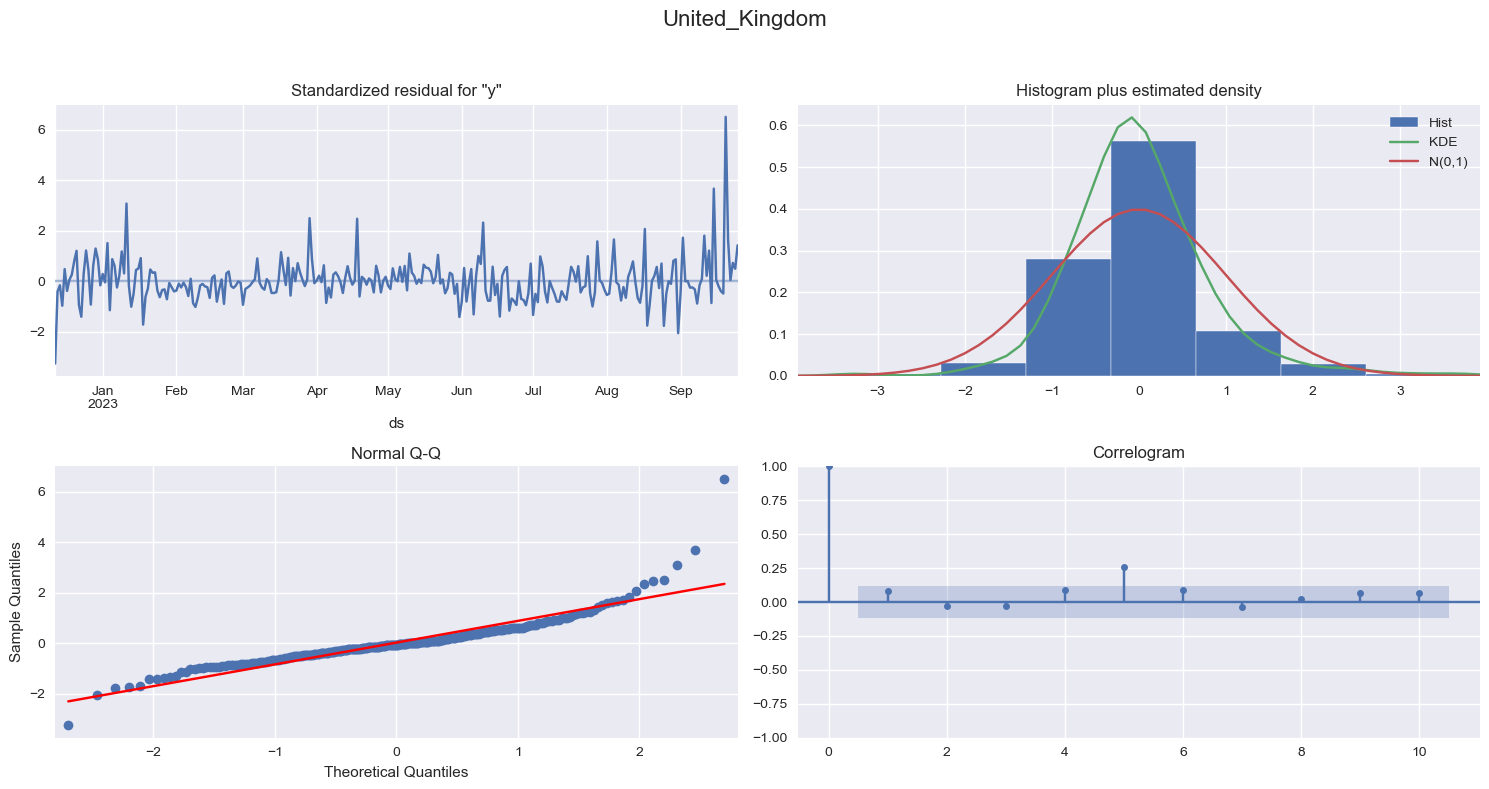

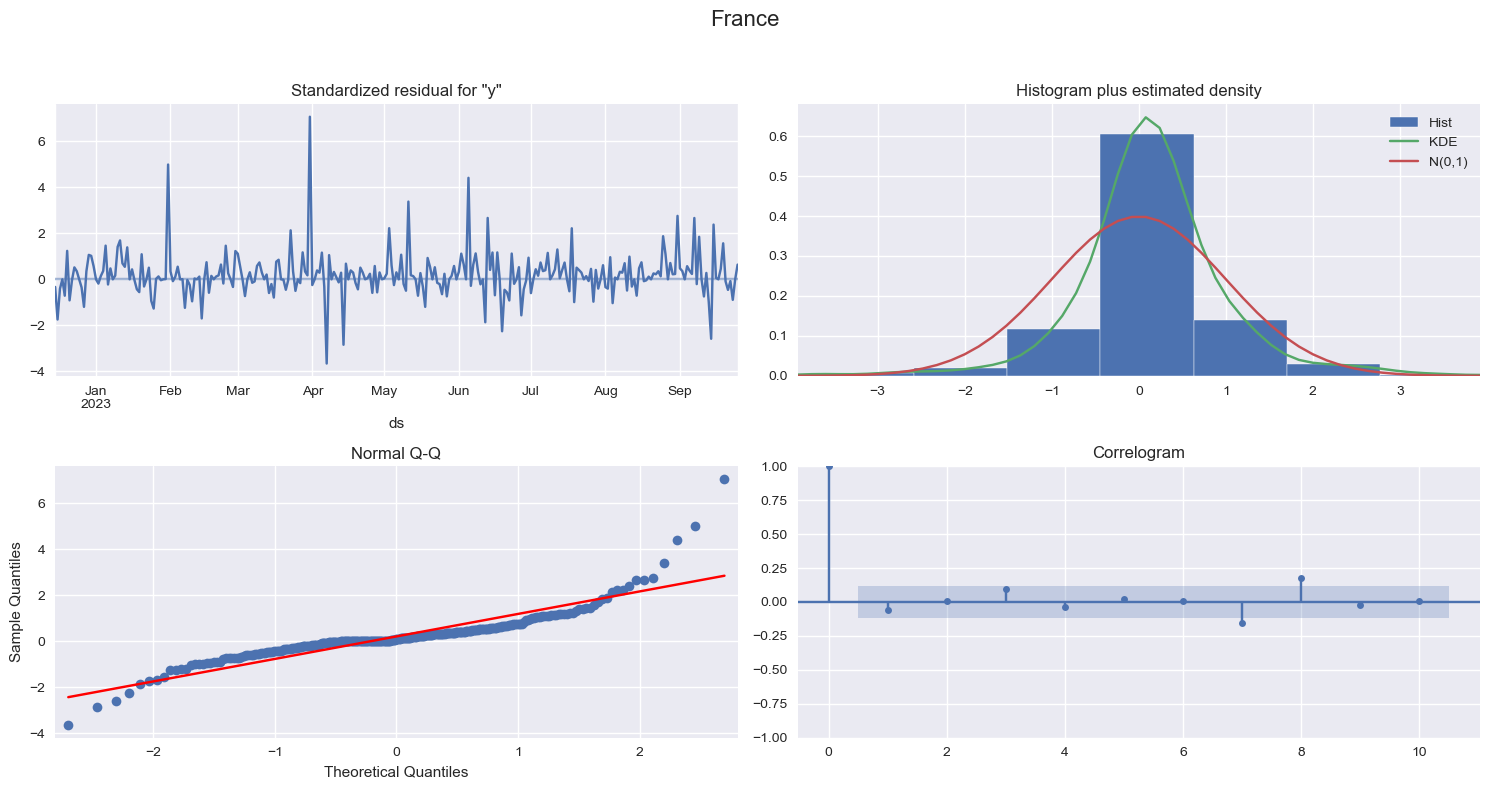

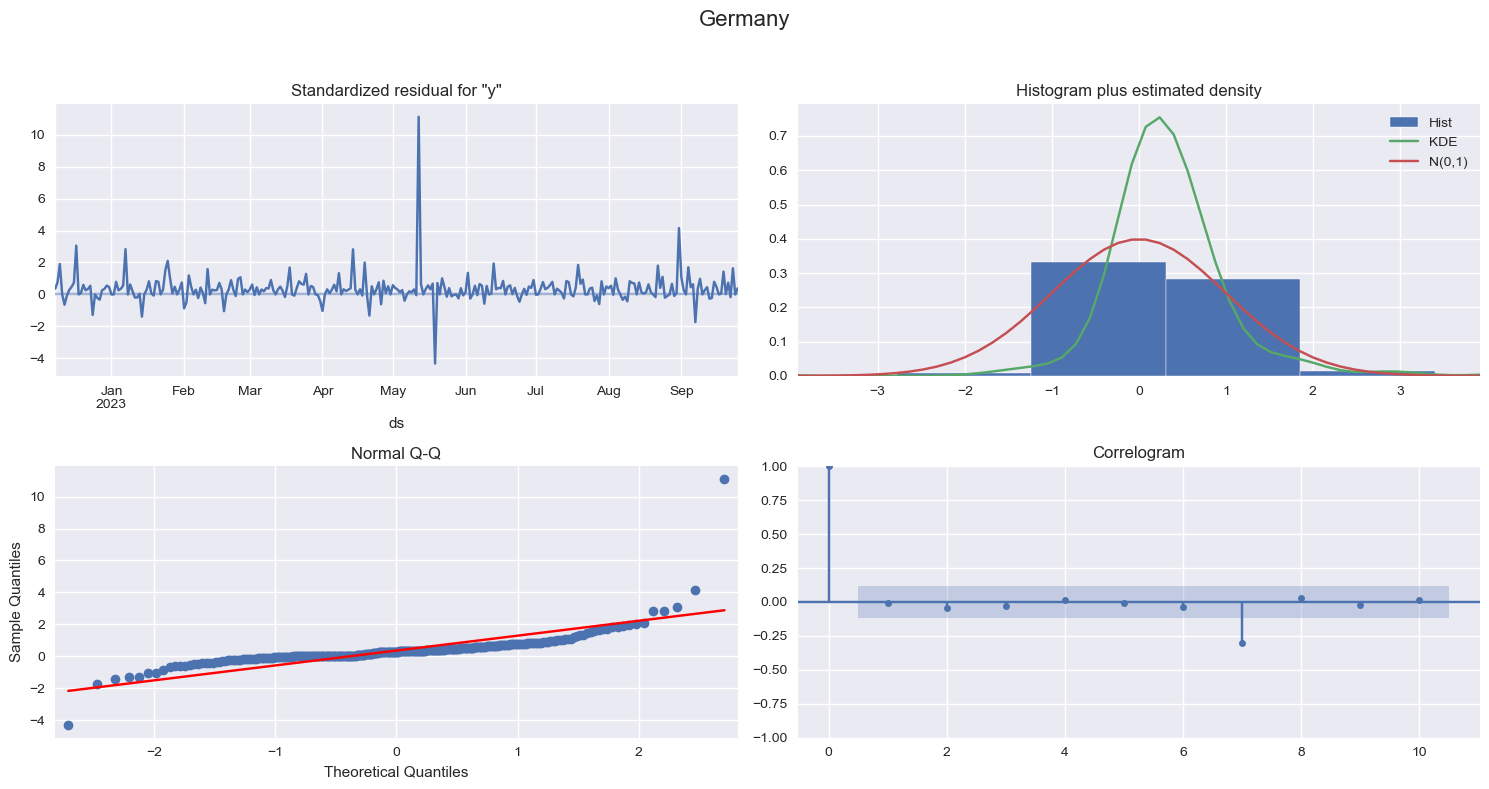

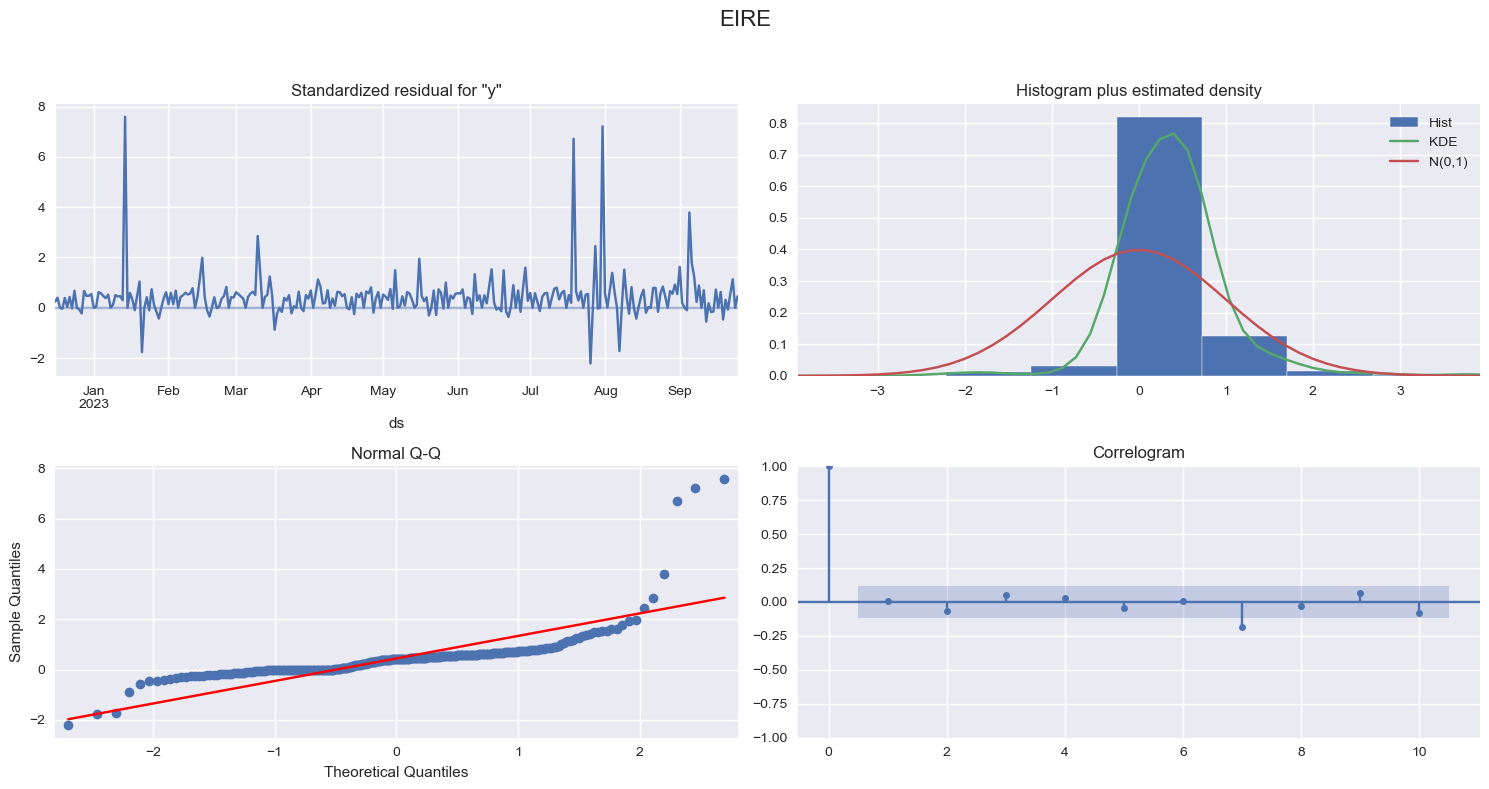

In [102]:
pd.options.plotting.backend = "matplotlib" #cambio el backend de gráficos a Matplotlib
rcParams['figure.figsize'] = 15, 8
for i in range(num_paises_imput):
    globals()[f'diagnostics_ar_{paises_abr_imput[i]}'] = globals()[resultados_ar[i]].plot_diagnostics()
    globals()[f'diagnostics_ar_{paises_abr_imput[i]}'].suptitle(f"{paises_imput[i]}", fontsize=16)
    globals()[f'diagnostics_ar_{paises_abr_imput[i]}'].tight_layout(rect=[0, 0, 1, 0.95])

#vuelvo a poner los ajustes que tenía:
pd.options.plotting.backend = "plotly"
rcParams['figure.figsize'] = 15, 12

Se observa en el gráfico de los cuantiles que a excepción de Irlanda, los puntos están bastante bien alineados (excepto al princpio y final de los datos)

Hago las predicciones patra los países de train+test+nuevo_mes (lo guardo en df_pais_ar)

In [103]:
for i in range(num_paises_imput):
    globals()[dfs_ar[i]]['yhat'] = globals()[resultados_ar[i]]\
        .predict(start=0,end=test_size+train_size+30, exog = df_uk_ar[train_size:][columns_exog]) #variables exogenas para las fechas de test+nuevo_mes
    #Pongo 0 en las fechas que la empresa esta cerrada
    globals()[dfs_ar[i]].loc[globals()[dfs_ar[i]]['cerrado']==1, 'yhat'] = 0
    
    print(f'Para {paises_imput[i]}:')
    display(globals()[dfs_ar[i]].head(1))
    display(globals()[dfs_ar[i]].tail(1))  
    print('------------------------------------')

Para United_Kingdom:


y  year  month  day_of_week  trimestre  cerrado  yhat
ds                                                                     
2022-12-01 53520.58  2022     12            3          4        0  0.00

y  year  month  day_of_week  trimestre  cerrado     yhat
ds                                                                   
2024-01-09 NaN  2024      1            1          1        0 21012.88

------------------------------------
Para France:


y  year  month  day_of_week  trimestre  cerrado  yhat
ds                                                                   
2022-12-01 792.90  2022     12            3          4        0  0.00

y  year  month  day_of_week  trimestre  cerrado   yhat
ds                                                                 
2024-01-09 NaN  2024      1            1          1        0 179.92

------------------------------------
Para Germany:


y  year  month  day_of_week  trimestre  cerrado  yhat
ds                                                                   
2022-12-01 261.48  2022     12            3          4        0  0.00

y  year  month  day_of_week  trimestre  cerrado  yhat
ds                                                                
2024-01-09 NaN  2024      1            1          1        0  0.12

------------------------------------
Para EIRE:


y  year  month  day_of_week  trimestre  cerrado  yhat
ds                                                                   
2022-12-01 483.08  2022     12            3          4        0  0.00

y  year  month  day_of_week  trimestre  cerrado  yhat
ds                                                                
2024-01-09 NaN  2024      1            1          1        0  0.00

------------------------------------


In [104]:
#Pinto las series para cada país
figs_ar = [f'fig_ar_{paises_abr_imput[i]}' for i in range(num_paises_imput)] # lista donde me guardo los gráficos de los 4 países
for i in range(num_paises_imput):
    df_temp = globals()[dfs_ar[i]].copy()
    globals()[figs_ar[i]] = px.line(df_temp, x = df_temp.index, y = [ 'y', 'yhat'], title = f'Modelo autoarima para {paises_imput[i]}')
    globals()[figs_ar[i]].add_vline(x=df_temp.iloc[train_size:].index[0].strftime('%Y-%m-%d'), line=dict( dash='dash', width=2), name ='entrenamiento-test')#linea vertical que me indica donde empieza el test
    globals()[figs_ar[i]].show()

No tienen muy buena pinta en Francia, Alemania e Irlanda; veamos las métricas para train-test

In [105]:
#Actualizo los dataframes de train, test y nuevo_mes con las predicciones
for i in range(num_paises_imput):
    globals()[trains_ar[i]] = globals()[dfs_ar[i]][:train_size]
    globals()[tests_ar[i]] = globals()[dfs_ar[i]][train_size:train_size+test_size]
    globals()[nuevos_meses_ar[i]] = globals()[dfs_ar[i]][train_size+test_size:] #el nuevo mes

    df_temp1 = errores(globals()[dfs_ar[i]][:train_size].query('y != 0')['y'],\
             globals()[dfs_ar[i]][:train_size].query('y != 0')['yhat'])
    df_temp2 = errores(globals()[dfs_ar[i]][train_size:train_size+test_size].query('y != 0')['y'],\
             globals()[dfs_ar[i]][train_size:train_size+test_size].query('y != 0')['yhat'])
    print(f'Errores para {paises_imput[i]}:')
    globals()[f'error_ar_{paises_abr_imput[i]}'] = pd.concat([df_temp1,df_temp2], axis=1)
    globals()[f'error_ar_{paises_abr_imput[i]}'].columns = ['Errores Train','Errores Test']
    display(globals()[f'error_ar_{paises_abr_imput[i]}'])

    errores_ar = [f'error_ar_{paises_abr_imput[i]}' for i in range(num_paises_imput)] #lista con los errores de los 4 paises


Errores para United_Kingdom:


Errores Train  Errores Test
MAE         10278.05      17949.16
RMSE        19584.88      24233.92
MAPE            0.44          0.39
SMAPE           0.37          0.46

Errores para France:


Errores Train  Errores Test
MAE           439.07        971.34
RMSE          673.76       1752.58
MAPE            1.75          0.82
SMAPE           0.63          0.93

Errores para Germany:


Errores Train  Errores Test
MAE           638.64       1122.71
RMSE         1127.63       1457.22
MAPE            0.79          0.95
SMAPE           0.84          1.68

Errores para EIRE:


Errores Train  Errores Test
MAE          1213.74       1610.64
RMSE         2044.17       1954.84
MAPE            0.84          0.97
SMAPE           1.04          1.88

No parece que vayan bien las órdenes que me calculó Autoarima en los 3 últimos países. Voy a usar las ordénes que me calcuó para Uk, ya que ahí si encaja mejor\
para el resto de países. Repito la definición de modelos, las predicciones y demás con este cambio.

In [106]:
#Ejecuto los modelos con los órdenes de UK
models_ar = [f'model_ar_{paises_abr_imput[i]}' for i in range(num_paises_imput)]
resultados_ar = [f'resultados_ar_{paises_abr_imput[i]}' for i in range(num_paises_imput)]
order_temp = globals()[f'auto_arima_{paises_abr_imput[0]}'].order
order_seasonal_temp = globals()[f'auto_arima_{paises_abr_imput[0]}'].seasonal_order  #Uso las órdenes de Uk
for i in range(num_paises_imput):
    globals()[f'model_ar_{paises_abr_imput[i]}'] = \
        SARIMAX(globals()[trains_ar[i]].y, order=order_temp, seasonal_order=order_seasonal_temp,
               enforce_stationarity=False,enforce_invertibility=False,
               exogenous=globals()[trains_ar[i]][columns_exog]) 
    globals()[f'resultados_ar_{paises_abr_imput[i]}'] = globals()[f'model_ar_{paises_abr_imput[i]}'].fit()

#Repito las predicciones
for i in range(num_paises_imput):
    globals()[dfs_ar[i]]['yhat'] = globals()[resultados_ar[i]]\
        .predict(start=0,end=test_size+train_size+30, exog = df_uk_ar[train_size:][columns_exog]) #variables exogenas para las fechas de test+nuevo_mes
    #Pongo 0 en las fechas que la empresa esta cerrada
    globals()[dfs_ar[i]].loc[globals()[dfs_ar[i]]['cerrado']==1, 'yhat'] = 0

#Vuelvo a pintar las series
#Pinto las series para cada país
figs_ar = [f'fig_ar_{paises_abr_imput[i]}' for i in range(num_paises_imput)] # lista donde me guardo los gráficos de los 4 países
for i in range(num_paises_imput):
    df_temp = globals()[dfs_ar[i]].copy()
    globals()[figs_ar[i]] = px.line(df_temp, x = df_temp.index, y = [ 'y', 'yhat'], title = f'Modelo autoarima para {paises_imput[i]}')
    globals()[figs_ar[i]].add_vline(x=df_temp.iloc[train_size:].index[0].strftime('%Y-%m-%d'), line=dict( dash='dash', width=2), name ='entrenamiento-test')#linea vertical que me indica donde empieza el test
    globals()[figs_ar[i]].show()

c:\Users\manue\anaconda3\envs\Nucliop\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\manue\anaconda3\envs\Nucliop\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\manue\anaconda3\envs\Nucliop\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Ahora se ve que se ajustan mucho mejor, voy a volver a calcular las métricas.

In [107]:
#Actualizo los dataframes de train, test y nuevo_mes 
for i in range(num_paises_imput):
    globals()[trains_ar[i]] = globals()[dfs_ar[i]][:train_size]
    globals()[tests_ar[i]] = globals()[dfs_ar[i]][train_size:train_size+test_size]
    globals()[nuevos_meses_ar[i]] = globals()[dfs_ar[i]][train_size+test_size:] #el nuevo mes

    df_temp1 = errores(globals()[dfs_ar[i]][:train_size].query('y != 0')['y'],\
             globals()[dfs_ar[i]][:train_size].query('y != 0')['yhat'])
    df_temp2 = errores(globals()[dfs_ar[i]][train_size:train_size+test_size].query('y != 0')['y'],\
             globals()[dfs_ar[i]][train_size:train_size+test_size].query('y != 0')['yhat'])
    print(f'Errores para {paises_imput[i]}:')
    globals()[f'error_ar_{paises_abr_imput[i]}'] = pd.concat([df_temp1,df_temp2], axis=1)
    globals()[f'error_ar_{paises_abr_imput[i]}'].columns = ['Errores Train','Errores Test']
    display(globals()[f'error_ar_{paises_abr_imput[i]}'])

    

Errores para United_Kingdom:


Errores Train  Errores Test
MAE         10278.05      17949.16
RMSE        19584.88      24233.92
MAPE            0.44          0.39
SMAPE           0.37          0.46

Errores para France:


Errores Train  Errores Test
MAE           373.47        749.45
RMSE          598.88       1537.99
MAPE            1.94          1.00
SMAPE           0.51          0.58

Errores para Germany:


Errores Train  Errores Test
MAE           466.89        632.00
RMSE          962.98        975.56
MAPE            1.14          1.09
SMAPE           0.50          0.55

Errores para EIRE:


Errores Train  Errores Test
MAE           785.41        771.70
RMSE         1724.76       1152.22
MAPE            0.95          1.06
SMAPE           0.49          0.48

#### Autoarima mes futuro

Voy a reentrenar los modelos usando todos los datos

In [108]:
#Vuelvo a definir los train, y test

# defino las listas donde voy a guardar los train_pais_ar, los test_pais_ar y los nuevo_mes_pais_ar
trains_ar_pred = [f'train_{paises_abr_imput[i]}_ar_pred' for i in range(num_paises_imput)]
tests_ar_pred = [f'test_{paises_abr_imput[i]}_ar_pred' for i in range(num_paises_imput)]


# Separo los datos en train_pais_ar,test_pais_ar y nuevo_mes_pais_ar para cada país
for i in range(num_paises_imput):
    globals()[trains_ar_pred[i]] = globals()[dfs_ar[i]][:train_size_pred]
    globals()[tests_ar_pred[i]] = globals()[dfs_ar[i]][train_size_pred:train_size_pred+test_size_pred]

    print(f'Tamaño de train-test para {paises_imput[i]}: {len(globals()[trains_ar_pred[i]])}-{len(globals()[tests_ar_pred[i]])}')  

Tamaño de train-test para United_Kingdom: 374-0
Tamaño de train-test para France: 374-0
Tamaño de train-test para Germany: 374-0
Tamaño de train-test para EIRE: 374-0


Ahora repito el mismo preoceso de antes con los nuevos conjuntos train-test

In [109]:

models_ar_pred = [f'model_ar_{paises_abr_imput[i]}_pred' for i in range(num_paises_imput)]
resultados_ar_pred = [f'resultados_ar_{paises_abr_imput[i]}_pred' for i in range(num_paises_imput)]
order_temp = globals()[f'auto_arima_{paises_abr_imput[0]}'].order
order_seasonal_temp = globals()[f'auto_arima_{paises_abr_imput[0]}'].seasonal_order  #Uso las órdenes de Uk
for i in range(num_paises_imput):
    globals()[f'model_ar_{paises_abr_imput[i]}_pred'] = \
        SARIMAX(globals()[trains_ar_pred[i]].y, order=order_temp, seasonal_order=order_seasonal_temp,
               enforce_stationarity=False,enforce_invertibility=False,
               exogenous=globals()[trains_ar_pred[i]][columns_exog]) 
    globals()[f'resultados_ar_{paises_abr_imput[i]}_pred'] = globals()[f'model_ar_{paises_abr_imput[i]}_pred'].fit()

#Repito las predicciones
dfs_ar_pred = [f'df_{paises_abr_imput[i]}_ar_pred' for i in range(num_paises_imput)]
for i in range(num_paises_imput):
    globals()[dfs_ar_pred[i]] = globals()[dfs_ar[i]]
    globals()[dfs_ar_pred[i]]['yhat'] = globals()[resultados_ar_pred[i]]\
        .predict(start=0,end=test_size+train_size+30, exog = df_uk_ar[train_size_pred:][columns_exog]) #variables exogenas para las fechas de test+nuevo_mes
    #Pongo 0 en las fechas que la empresa esta cerrada
    globals()[dfs_ar_pred[i]].loc[globals()[dfs_ar_pred[i]]['cerrado']==1, 'yhat'] = 0

#Vuelvo a pintar las series
#Pinto las series para cada país
figs_ar_pred = [f'fig_ar_{paises_abr_imput[i]}_pred' for i in range(num_paises_imput)] # lista donde me guardo los gráficos de los 4 países
for i in range(num_paises_imput):
    df_temp = globals()[dfs_ar_pred[i]].copy()
    globals()[figs_ar_pred[i]] = px.line(df_temp, x = df_temp.index, y = [ 'y', 'yhat'], title = f'Modelo auto_predima p_preda {paises_imput[i]}')
    globals()[figs_ar_pred[i]].add_vline(x=df_temp.iloc[train_size_pred:].index[0].strftime('%Y-%m-%d'), line=dict( dash='dash', width=2), name ='entrenamiento-test')#linea vertical que me indica donde empieza el test
    globals()[figs_ar_pred[i]].show()

c:\Users\manue\anaconda3\envs\Nucliop\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



### Mejor Modelo

Para cada país, voy a calcular los errores de los conjuntos train_pred (aquellos en los que son todos los datos disponibles) para los días en los que la empresa esté abierta

In [110]:
for i in range(num_paises_imput):
    print (f'Errores de Prophet, Catboost y Sarimax para {paises_imput[i]}')
    #errores de Prophet
    df_temp1 = globals()[trains_prop_pred[i]].query('y != 0')
    df_temp2 = globals()[forecasts_prop_clean_pred[i][:train_size_pred]]
    df_temp2 = df_temp2[df_temp2.ds.isin(df_temp1.ds)]['yhat']

    df_temp3 = globals()[dfs_cat_pred[i]][:train_size_pred].query('y != 0').y #valores reales
    df_temp4 = globals()[dfs_cat_pred[i]][:train_size_pred].query('y != 0').yhat #predicciones cat

    df_temp5 = globals()[dfs_ar_pred[i]][:train_size_pred].query('y != 0').y
    df_temp6 = globals()[dfs_ar_pred[i]][:train_size_pred].query('y != 0').yhat

    globals()[f'error_pred_{paises_imput[i]}'] = pd.concat([errores(df_temp1.y,df_temp2), errores(df_temp3,df_temp4), errores(df_temp5,df_temp6)], axis=1)
    globals()[f'error_pred_{paises_imput[i]}'].columns = ['Prophet','Catboost', 'Sarimax']
    display(globals()[f'error_pred_{paises_imput[i]}'])
errores_pred = [f'error_pred_{paises_imput[i]}' for i in range(num_paises_imput)]

Errores de Prophet, Catboost y Sarimax para United_Kingdom


Prophet  Catboost  Sarimax
MAE    9691.18   7426.85 11535.24
RMSE  12736.09  10857.51 21117.77
MAPE      0.47      0.33     0.46
SMAPE     0.35      0.28     0.38

Errores de Prophet, Catboost y Sarimax para France


Prophet  Catboost  Sarimax
MAE     437.28    422.32   471.58
RMSE    873.82    811.65   852.15
MAPE      1.15      1.62     1.61
SMAPE     0.51      0.48     0.54

Errores de Prophet, Catboost y Sarimax para Germany


Prophet  Catboost  Sarimax
MAE     491.38    425.12   514.36
RMSE    963.02    755.84   964.33
MAPE      1.02      1.12     1.20
SMAPE     0.51      0.45     0.52

Errores de Prophet, Catboost y Sarimax para EIRE


Prophet  Catboost  Sarimax
MAE     740.20    705.23   770.74
RMSE   1608.13   1552.27  1622.85
MAPE      0.81      1.03     0.94
SMAPE     0.47      0.43     0.49

El error MAPE calcula el error relativo del modelo, y el SMAPE es parecido pero reduce la influencia de valores pequeños por tanto es más adecuado para\
los países que tienen valores más pequeños.

El error SMAPE y los MAE,RMSE son más pequeños en Catboost que en el resto de países para todos los países. Así que usaría Catboost para todos


## Paises sin modelar-Conclusiones finales

Recordemos que hay 6 países que tenía tan pocos datos que decidí no modelar

In [111]:
paises_sin_imput = [x for x in paises if x not in paises_imput]
paises_abr_sin_imput = [x for x in paises_abr if x not in paises_abr_imput]
dfs_sin_imp = [x for x in dfs if x not in dfs_imput]
display(paises_sin_imput)
display(paises_abr_sin_imput)
display(dfs_sin_imp)
num_paises_sin_imput = len(paises_sin_imput)

['Netherlands', 'Spain', 'Portugal', 'Italy', 'Belgium', 'Sweden']

['neth', 'spain', 'port', 'it', 'bel', 'swe']

['df_neth', 'df_spain', 'df_port', 'df_it', 'df_bel', 'df_swe']

In [112]:

import calendar
# Voy a ver el numero de fechas disponibles por mes en cada país

# Crear subplots
fig = make_subplots(rows=3, cols=2, subplot_titles=paises_sin_imput)

# Añadir gráficos a las subplots
for i in range(num_paises_sin_imput):
    df_temp = globals()[dfs_sin_imp[i]].groupby('month').agg(ventas_por_mes=('ventas_diarias', 'count')).copy()
    df_temp.sort_index(inplace=True)
    df_temp.index = list(calendar.month_name)[1:]

    # Crear gráfico de barras
    bar = go.Bar(x=df_temp.index, y=df_temp['ventas_por_mes'] , name=paises_sin_imput[i], text=df_temp['ventas_por_mes'], textangle=0)

    # Determinar la fila y columna
    row = (i // 2) + 1 #paises 0,1 en la primera fila; paises 2,3 en la segunda fila...
    col = (i % 2) + 1  #paises pares en la columna 1; países impares en la columna 2

    # Añadir el gráfico a la figura
    fig.add_trace(bar, row=row, col=col)

# Actualizar diseño
fig.update_layout(
    height=200*num_paises_sin_imput,  # Ajustar la altura total
    width= 1000,   # Ajustar el ancho total
    showlegend=False    # Ocultar leyenda global
)

# Mostrar figura
fig.show()


Todos los meses tienen al menos una venta. Para estos países también podría imputar nulos y hacer un modelo para predecir el futuro.\
Pero teniendo tan pocos datos (recuerdo los porcentajes abajo) tendría que la mayoría de mis fechas son imputadas, y por tanto, tendrían un error grande o pequeño pero error.\
Así que a la hora de predecir se acumulan los errores de las predicciones futuras con los errores de las imputaciones (que es un porcentaje muy elevado).

Por tanto, como resulta que estas series eran estacionarias, como ya vimos antes(y como vuelvo a visualizar abajo) para el mes siguiente que quiero predecir,\
utilizaría las ventas totales  de ese mismo mes hace 1 año como predicción.\
Es decir,no intentaría predecir las ventas diarias del siguiente mes, sino las ventas totales del siguiente mes.

In [113]:
display(df_paises.loc[paises_sin_imput])

for i in range(num_paises_sin_imput):
    result = adfuller(globals()[dfs_sin_imp[i]]['ventas_diarias'])
    if result[1] <0.05:
        print(f'La serie de {paises_abr[i]} es estacionaria, p-valor = {round(result[1],7)}')
    else:
        print(f'La serie de {paises_abr[i]} no es estacionaria, p-valor = {round(result[1],7)}', )


num_fechas_totales  empresa_abierta  fechas_faltantes  \
Netherlands                 117               61               257   
Spain                       132               76               242   
Portugal                    102               46               272   
Italy                        87               31               287   
Belgium                     139               83               235   
Sweden                       88               32               286   

             pct_faltantes  pct_faltantes_empresa_abierta  \
Netherlands          68.72                          80.82   
Spain                64.71                          76.10   
Portugal             72.73                          85.53   
Italy                76.74                          90.25   
Belgium              62.83                          73.90   
Sweden               76.47                          89.94   

             pct_fechas_empresa_abierta  
Netherlands                       19.18  
Spain                             23.90  
Portugal                          14.47  
Italy                              9.75  
Belgium                           26.10  
Sweden                            10.06

La serie de uk es estacionaria, p-valor = 0.0
La serie de fr es estacionaria, p-valor = 0.0
La serie de neth es estacionaria, p-valor = 0.0
La serie de ger es estacionaria, p-valor = 0.000674
La serie de eire es estacionaria, p-valor = 0.0182786
La serie de spain es estacionaria, p-valor = 0.0


Para terminar, vuelvo a incidir en que al tener solo un año de datos, no se puede calcular una posible estacionalidad anual(por ejemplo más ventas en Navidad).\
Tampoco podemos ver si respecto a años atrás ha habido una tendencia ascendente o descendente en el número de ventas. Y tampoco podemos comprobar si los outliers tan grandes\
que tenemos en todos los países han sido recurrentes a lo largo de los años.

Por otro lado, solo en Uk se tenían practicamente todos los datos, por tanto es el más fiable para predecir. A los demás, como he comentado arriba, a los errores de las predicciones\
hay que sumarle los errores de las imputaciones. 